## 1. Data Preparation

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statistics as stats
import calendar
from datetime import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read price, train and test data
trainData = pd.read_csv("data/train.csv")
testData = pd.read_csv("data/test.csv")
priceData = pd.read_csv("data/price.csv")

index = testData["index"]
                      
testData.drop("index", axis= 1, inplace=True)

priceData.rename(columns={"Validfrom": "Date", "City Code": "CityCode"}, inplace=True)
trainData.rename(columns={"Billing Date": "Date", "City Code": "CityCode"}, inplace=True)
testData.rename(columns={"Week Start Date": "Date", "City Code": "CityCode"}, inplace=True)

# concat train and test data
data = pd.concat([trainData, testData], sort=True).reset_index(drop=True)

print(f'Number of Training Examples = {trainData.shape[0]}')
print(f'Number of Test Examples = {testData.shape[0]}')
print(f'Data Shape = {data.shape}')

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1379259], all_data.loc[1379260:]

Number of Training Examples = 1379260
Number of Test Examples = 108472
Data Shape = (1487732, 7)


In [3]:
data = pd.merge(data, priceData[["CityCode", "Date", "Product", "CRP"]],
                on=["CityCode", "Date", "Product"], how="left")

# change the dtype as object 
data['CityCode'] = data['CityCode'].astype('object')
data['Customer'] = data['Customer'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Area      1487732 non-null  object 
 1   CityCode  1487732 non-null  object 
 2   Customer  1487732 non-null  object 
 3   Date      1487732 non-null  object 
 4   Litres    1379260 non-null  float64
 5   Plant     1379260 non-null  object 
 6   Product   1487732 non-null  object 
 7   CRP       1467957 non-null  float64
dtypes: float64(2), object(6)
memory usage: 102.2+ MB


In [4]:
# function to find day of the week based on the date field
def findDay(date): 
    dayname = calendar.day_name[date.weekday()]
    return dayname

# convert the 'Date' column to datetime format
data['Date']= pd.to_datetime(data['Date'])

# create Year, Month, Day, DayNames columns
data['Year'] = data["Date"].dt.year
data['Month'] = data["Date"].dt.month
data['Day'] = data["Date"].dt.day
data['DayNames'] = data['Date'].apply(lambda x: findDay(x))
data.head()

Area CityCode  Customer       Date   Litres Plant  Product  \
0  Karadeniz Bölgesi      883  10048261 2014-01-01      0.0  T102   Benzin   
1  Karadeniz Bölgesi      883  10048261 2014-01-01      0.0  T155   Benzin   
2  Karadeniz Bölgesi      883  10048261 2014-01-01      0.0  T102  Motorin   
3  Karadeniz Bölgesi      883  10048261 2014-01-01      0.0  T155  Motorin   
4  Karadeniz Bölgesi      883  10048261 2014-01-02  16685.0  T155  Motorin   

    CRP  Year  Month  Day   DayNames  
0  4.98  2014      1    1  Wednesday  
1  4.98  2014      1    1  Wednesday  
2  4.58  2014      1    1  Wednesday  
3  4.58  2014      1    1  Wednesday  
4  4.65  2014      1    2   Thursday

In [5]:
# filling the missing values in CRP with the mean of Year, Month and Product groups
data['CRP'] = data.groupby(['Year', 'Month', 'Product'])['CRP'].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 12 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Area      1487732 non-null  object        
 1   CityCode  1487732 non-null  object        
 2   Customer  1487732 non-null  object        
 3   Date      1487732 non-null  datetime64[ns]
 4   Litres    1379260 non-null  float64       
 5   Plant     1379260 non-null  object        
 6   Product   1487732 non-null  object        
 7   CRP       1487732 non-null  float64       
 8   Year      1487732 non-null  int64         
 9   Month     1487732 non-null  int64         
 10  Day       1487732 non-null  int64         
 11  DayNames  1487732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 147.6+ MB


In [6]:
# filling the missing values in plant with the mode of Area and CityCode
def fill_missing_values(x):
    return x.fillna(stats.mode(x))

data['Plant'] = data.groupby(['Area', 'CityCode'])['Plant'].apply(fill_missing_values)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 12 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Area      1487732 non-null  object        
 1   CityCode  1487732 non-null  object        
 2   Customer  1487732 non-null  object        
 3   Date      1487732 non-null  datetime64[ns]
 4   Litres    1379260 non-null  float64       
 5   Plant     1487628 non-null  object        
 6   Product   1487732 non-null  object        
 7   CRP       1487732 non-null  float64       
 8   Year      1487732 non-null  int64         
 9   Month     1487732 non-null  int64         
 10  Day       1487732 non-null  int64         
 11  DayNames  1487732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 147.6+ MB


In [7]:
# still there are some missing values
# filling the missing values in Plant with the mode of Area and Product
data['Plant'] = data.groupby(['Area', 'Product'])['Plant'].apply(fill_missing_values)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 12 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Area      1487732 non-null  object        
 1   CityCode  1487732 non-null  object        
 2   Customer  1487732 non-null  object        
 3   Date      1487732 non-null  datetime64[ns]
 4   Litres    1379260 non-null  float64       
 5   Plant     1487732 non-null  object        
 6   Product   1487732 non-null  object        
 7   CRP       1487732 non-null  float64       
 8   Year      1487732 non-null  int64         
 9   Month     1487732 non-null  int64         
 10  Day       1487732 non-null  int64         
 11  DayNames  1487732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 147.6+ MB


In [8]:
data[["Area", "CityCode", "Customer", "Plant", "Product", "DayNames"]].describe()

Area  CityCode  Customer    Plant  Product DayNames
count           1487732   1487732   1487732  1487732  1487732  1487732
unique                7        76      1275       17        2        7
top     Marmara Bölgesi       835  10049419     T314  Motorin   Monday
freq             622365    357229      3828   271733   893177   340038

## 2. Feature Engineering

#### 2.1 USD/TRY 

In [10]:
# read USD/TRY historical data
USD_TRY = pd.read_csv("data/USD_TRY.csv")

USD_TRY.rename(columns={"Tarih": "Date", "Açılış": "USD/TRY"}, inplace=True)

# convert the 'Date' column to datetime format
USD_TRY['Date']= pd.to_datetime(USD_TRY['Date'])

# information about USD/TRY data
USD_TRY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8150 entries, 0 to 8149
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8150 non-null   datetime64[ns]
 1   Şimdi    8150 non-null   object        
 2   USD/TRY  8150 non-null   object        
 3   Yüksek   8150 non-null   object        
 4   Düşük    8150 non-null   object        
 5   Fark %   8150 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 382.2+ KB


In [11]:
# there are "," in the USD/TRY column and we need to change to "." them
USD_TRY['USD/TRY'] = USD_TRY['USD/TRY'].str.replace(',', ".")

# change the dtype as float64 
USD_TRY['USD/TRY'] = USD_TRY['USD/TRY'].astype('float64')

In [12]:
data = pd.merge(data, USD_TRY[["Date", "USD/TRY"]],
               on=["Date"], how="left")

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 13 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Area      1487732 non-null  object        
 1   CityCode  1487732 non-null  object        
 2   Customer  1487732 non-null  object        
 3   Date      1487732 non-null  datetime64[ns]
 4   Litres    1379260 non-null  float64       
 5   Plant     1487732 non-null  object        
 6   Product   1487732 non-null  object        
 7   CRP       1487732 non-null  float64       
 8   Year      1487732 non-null  int64         
 9   Month     1487732 non-null  int64         
 10  Day       1487732 non-null  int64         
 11  DayNames  1487732 non-null  object        
 12  USD/TRY   1147321 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 158.9+ MB


In [13]:
# there is no data for each day because forex market is close in holidays 
# filling the missing values in USD/TRY with the mean of Year and Month groups
data['USD/TRY'] = data.groupby(['Year', 'Month'])['USD/TRY'].apply(lambda x: x.fillna(x.mean()))
data["USD/TRY"] = np.round(data["USD/TRY"], 2)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 13 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Area      1487732 non-null  object        
 1   CityCode  1487732 non-null  object        
 2   Customer  1487732 non-null  object        
 3   Date      1487732 non-null  datetime64[ns]
 4   Litres    1379260 non-null  float64       
 5   Plant     1487732 non-null  object        
 6   Product   1487732 non-null  object        
 7   CRP       1487732 non-null  float64       
 8   Year      1487732 non-null  int64         
 9   Month     1487732 non-null  int64         
 10  Day       1487732 non-null  int64         
 11  DayNames  1487732 non-null  object        
 12  USD/TRY   1487732 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 158.9+ MB


#### 2.2 Population

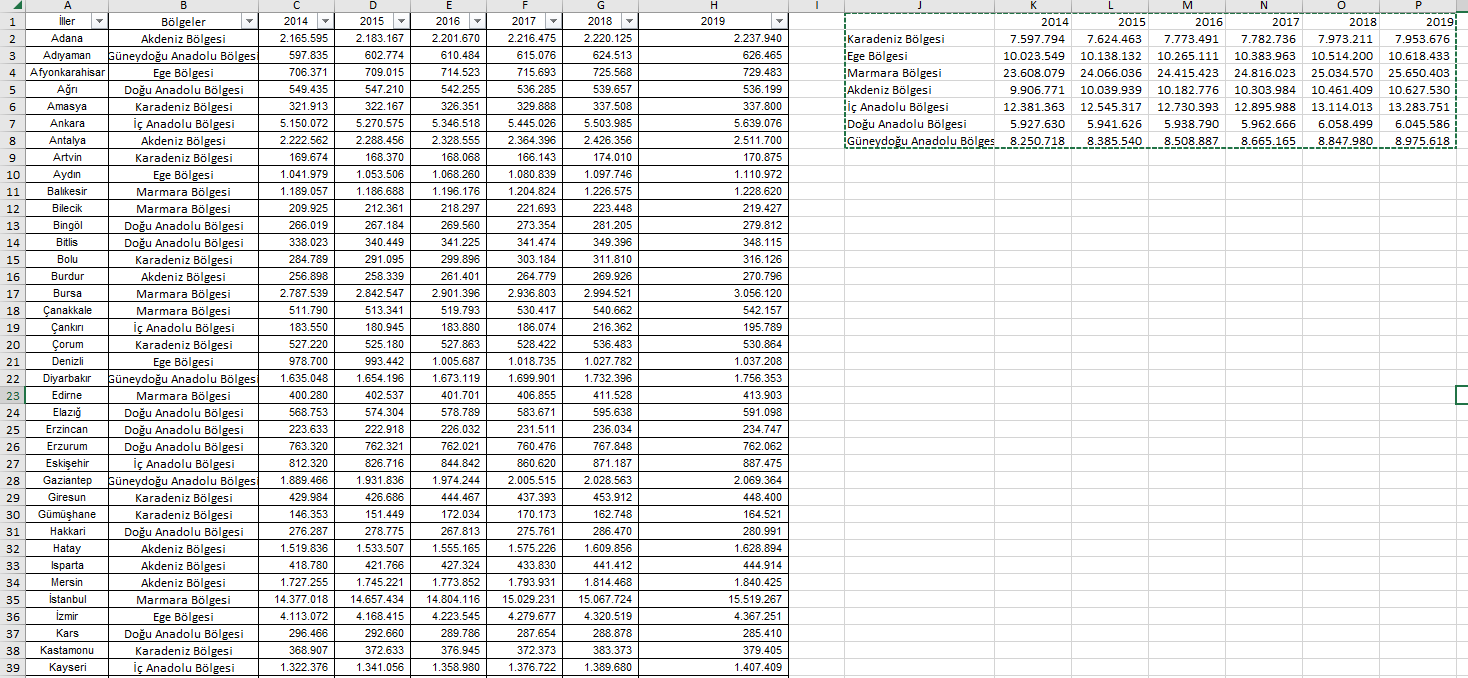
This data is taken from the https://data.tuik.gov.tr/Search/Search?text=Yıllara%20Göre%20İl%20Nüfusları

In [14]:
region = {'Region': ['Karadeniz Bölgesi', 'Ege Bölgesi', 'Marmara Bölgesi', 'Akdeniz Bölgesi', 'İç Anadolu Bölgesi', 'Doğu Anadolu Bölgesi', 'Güneydoğu Anadolu Bölgesi'],
          '2014': [7597894, 10023549, 23608079, 9907771, 12381363, 5927630, 8250718],
          '2015': [7624463, 10138132, 24066036, 10039939, 12545317, 5941626, 8385540],
          '2016': [7773491, 10265111, 24415423, 10182776, 12732393, 5938790, 8508887],
          '2017': [7782736, 10383963, 24816023, 10303984, 12895998, 5962666, 8665165],
          '2018': [7973211, 10514200, 25034570, 10461409, 13114013, 6058499, 8847980],
          '2019': [7953676, 10618433, 25650403, 10627530, 13283751, 6045586, 8975618]}

region = pd.DataFrame(region)
region

Region      2014      2015      2016      2017  \
0          Karadeniz Bölgesi   7597894   7624463   7773491   7782736   
1                Ege Bölgesi  10023549  10138132  10265111  10383963   
2            Marmara Bölgesi  23608079  24066036  24415423  24816023   
3            Akdeniz Bölgesi   9907771  10039939  10182776  10303984   
4         İç Anadolu Bölgesi  12381363  12545317  12732393  12895998   
5       Doğu Anadolu Bölgesi   5927630   5941626   5938790   5962666   
6  Güneydoğu Anadolu Bölgesi   8250718   8385540   8508887   8665165   

       2018      2019  
0   7973211   7953676  
1  10514200  10618433  
2  25034570  25650403  
3  10461409  10627530  
4  13114013  13283751  
5   6058499   6045586  
6   8847980   8975618

In [15]:
population = []
for col1, col2 in zip(data['Area'], data['Year']):
    population.append(region[region["Region"] == f"{col1}"][f"{col2}"])

data["Population"] = population

# change the dtype as int64
data["Population"] = data["Population"].astype('int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Area        1487732 non-null  object        
 1   CityCode    1487732 non-null  object        
 2   Customer    1487732 non-null  object        
 3   Date        1487732 non-null  datetime64[ns]
 4   Litres      1379260 non-null  float64       
 5   Plant       1487732 non-null  object        
 6   Product     1487732 non-null  object        
 7   CRP         1487732 non-null  float64       
 8   Year        1487732 non-null  int64         
 9   Month       1487732 non-null  int64         
 10  Day         1487732 non-null  int64         
 11  DayNames    1487732 non-null  object        
 12  USD/TRY     1487732 non-null  float64       
 13  Population  1487732 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(6)
memory usage: 170.3+ MB


#### 2.3 Number of Motor Vehicles by Fuel Type

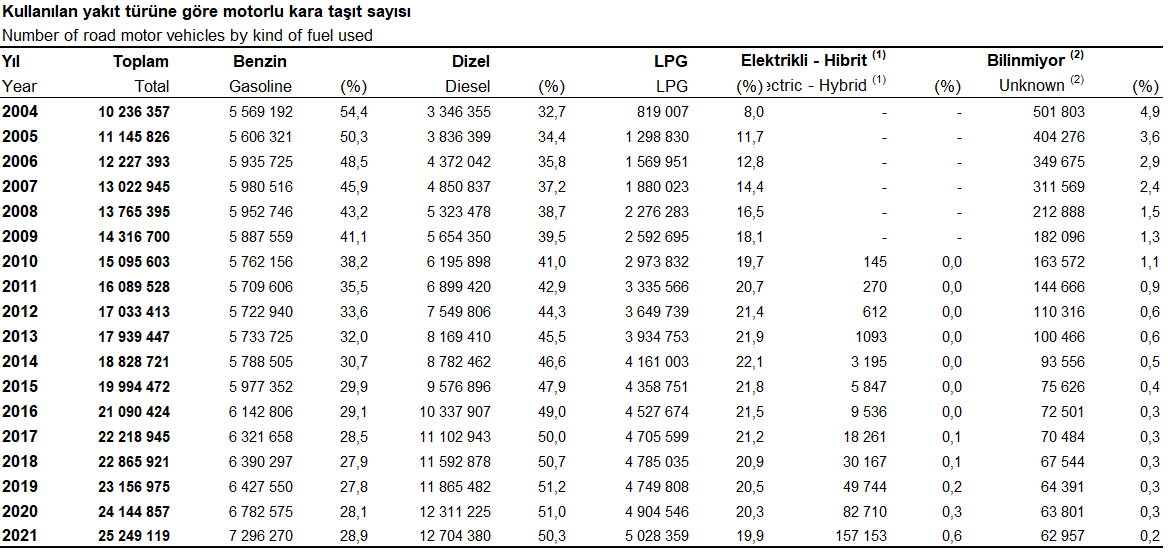
This data is taken from the https://data.tuik.gov.tr/Search/Search?text=Motorlu%20Kara%20Ta%C5%9F%C4%B1tlar%C4%B1

In [16]:
df = pd.DataFrame({'Year': [2014, 2015, 2016, 2017, 2018, 2019],
                   'Benzin': [5788505, 5977352, 6142806, 6321508, 6390297, 6427550],
                   'Motorin': [8782462, 9576896, 10337907, 11102943, 11592878, 11865482]})

df

Year   Benzin   Motorin
0  2014  5788505   8782462
1  2015  5977352   9576896
2  2016  6142806  10337907
3  2017  6321508  11102943
4  2018  6390297  11592878
5  2019  6427550  11865482

In [17]:
VehiclesNumber = []
for col1, col2 in zip(data['Year'], data['Product']):
    if col1 == 2014 and col2 == "Benzin":
        VehiclesNumber.append(5788505)
    elif col1 == 2014 and col2 == "Motorin":
        VehiclesNumber.append(8782462)
    elif col1 == 2015 and col2 == "Benzin":
        VehiclesNumber.append(5977352)
    elif col1 == 2015 and col2 == "Motorin":
        VehiclesNumber.append(9576896)
    elif col1 == 2016 and col2 == "Benzin":
        VehiclesNumber.append(6142806)
    elif col1 == 2016 and col2 == "Motorin":
        VehiclesNumber.append(10337907)  
    elif col1 == 2017 and col2 == "Benzin":
        VehiclesNumber.append(6321508)
    elif col1 == 2017 and col2 == "Motorin":
        VehiclesNumber.append(11102943)
    elif col1 == 2018 and col2 == "Benzin":
        VehiclesNumber.append(6390297)
    elif col1 == 2018 and col2 == "Motorin":
        VehiclesNumber.append(11592878) 
    elif col1 == 2019 and col2 == "Benzin":
        VehiclesNumber.append(6427550)
    elif col1 == 2019 and col2 == "Motorin":
        VehiclesNumber.append(11865482)

        
# for col1, col2 in zip(data['Year'], data['Product']):
    # VehiclesNumber.append(df[df["Year"] == col1][f"{col2}"])
    

data["VehiclesNumber"] = VehiclesNumber
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Area            1487732 non-null  object        
 1   CityCode        1487732 non-null  object        
 2   Customer        1487732 non-null  object        
 3   Date            1487732 non-null  datetime64[ns]
 4   Litres          1379260 non-null  float64       
 5   Plant           1487732 non-null  object        
 6   Product         1487732 non-null  object        
 7   CRP             1487732 non-null  float64       
 8   Year            1487732 non-null  int64         
 9   Month           1487732 non-null  int64         
 10  Day             1487732 non-null  int64         
 11  DayNames        1487732 non-null  object        
 12  USD/TRY         1487732 non-null  float64       
 13  Population      1487732 non-null  int64         
 14  VehiclesNumber  14

#### 2.4 Minimum Wage in Türkiye

In [18]:
# https://tr.wikipedia.org/wiki/T%C3%BCrkiye%27de_asgari_%C3%BCcret there are information about min wage in Turkey
# according to this information
# Year TL
# 2014 891
# 2015 1000,54
# 2016 1300,99
# 2017 1404
# 2018 1603
# 2019 2020,59

MinWage = []
for i in data["Year"]:
    if i == 2014:
        MinWage.append(891)
    elif i == 2015:
        MinWage.append(1000.54)
    elif i == 2016:
        MinWage.append(1300.99)
    elif i == 2017:
        MinWage.append(1404)
    elif i == 2018:
        MinWage.append(1603)
    elif i == 2019:
        MinWage.append(2020.59)
        
data["MinumumWage"] = MinWage
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Area            1487732 non-null  object        
 1   CityCode        1487732 non-null  object        
 2   Customer        1487732 non-null  object        
 3   Date            1487732 non-null  datetime64[ns]
 4   Litres          1379260 non-null  float64       
 5   Plant           1487732 non-null  object        
 6   Product         1487732 non-null  object        
 7   CRP             1487732 non-null  float64       
 8   Year            1487732 non-null  int64         
 9   Month           1487732 non-null  int64         
 10  Day             1487732 non-null  int64         
 11  DayNames        1487732 non-null  object        
 12  USD/TRY         1487732 non-null  float64       
 13  Population      1487732 non-null  int64         
 14  VehiclesNumber  14

#### 2.5 Amount of Fuel That Can Be Purchased with a Minimum Wage

In [19]:
# How much fuel can be purchased with minumum wage
data["FuelAmount"] = data["MinumumWage"] / data["CRP"]
data["FuelAmount"] = np.round(data["FuelAmount"], 2)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Area            1487732 non-null  object        
 1   CityCode        1487732 non-null  object        
 2   Customer        1487732 non-null  object        
 3   Date            1487732 non-null  datetime64[ns]
 4   Litres          1379260 non-null  float64       
 5   Plant           1487732 non-null  object        
 6   Product         1487732 non-null  object        
 7   CRP             1487732 non-null  float64       
 8   Year            1487732 non-null  int64         
 9   Month           1487732 non-null  int64         
 10  Day             1487732 non-null  int64         
 11  DayNames        1487732 non-null  object        
 12  USD/TRY         1487732 non-null  float64       
 13  Population      1487732 non-null  int64         
 14  VehiclesNumber  14

#### 2.6 Tax and Tax Rates

Special Consumption Tax Amounts and Rates Data 
taken from the https://www.gib.gov.tr/sites/default/files/fileadmin/mevzuatek/otv_oranlari_tum/ozeltuketimoranlari-OpenPage.htm

In [20]:
# create TaxAmount and TaxRates column
data["TaxAmount"] = None
data["TaxRates"] = None

In [21]:
# in 2014 and 2015 2,1765 TL Total Tax for Benzin and 1,5945 TL Total Tax for Motorin
# 2014
data.loc[(data["Year"] == 2014) & (data["Product"] == "Benzin"), "TaxAmount"] = 2.1765
data.loc[(data["Year"] == 2014) & (data["Product"] == "Motorin"), "TaxAmount"] = 1.5945

# 2015
data.loc[(data["Year"] == 2015) & (data["Product"] == "Benzin"), "TaxAmount"] = 2.1765
data.loc[(data["Year"] == 2015) & (data["Product"] == "Motorin"), "TaxAmount"] = 1.5945

In [22]:
# in 2016 and 2017 2,3765 TL Total Tax for Benzin and 1,7945 TL Total Tax for Motorin
# 2016
data.loc[(data["Year"] == 2016) & (data["Product"] == "Benzin"), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2016) & (data["Product"] == "Motorin"), "TaxAmount"] = 1.7945

# 2017
data.loc[(data["Year"] == 2017) & (data["Product"] == "Benzin"), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2017) & (data["Product"] == "Motorin"), "TaxAmount"] = 1.7945

In [26]:
# In 2018, the total tax varies for each month and day.
# in 1,2,3,4 Month 2,3765 TL Total Tax for Benzin and 1,7945 TL Total Tax for Motorin
# in 5 Month 2,0832 TL Total Tax for Benzin and 1,5275 TL Total Tax for Motorin
# in 6 Month 2,1842 TL Total Tax for Benzin and 1,6210 TL Total Tax for Motorin
# in 7 Month 2,1748 TL Total Tax for Benzin and 1,6210 TL Total Tax for Motorin
# in 8 Month 1,85 TL Total Tax for Benzin and 1,3082 TL Total Tax for Motorin
# in 9 Month 1,6533 TL Total Tax for Benzin and 0,9205 TL Total Tax for Motorin
# in 10 Month 1,9090 TL Total Tax for Benzin and 1,0262 TL Total Tax for Motorin
# in 11 Month 2,3716 TL Total Tax for Benzin and 1,5268 TL Total Tax for Motorin
# in 12 Month 2,3765 TL Total Tax for Benzin and 1,7945 TL Total Tax for Motorin

# Month 1, 2, 3, 4
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([1, 2, 3, 4])), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([1, 2, 3, 4])), "TaxAmount"] = 1.7945
# Month 5
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([5])), "TaxAmount"] = 2.0832
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([5])), "TaxAmount"] = 1.5275
# Month 6
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([6])), "TaxAmount"] = 2.1842
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([6])), "TaxAmount"] = 1.6210
# Month 7
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([7])), "TaxAmount"] = 2.1748
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([7])), "TaxAmount"] = 1.6210
# Month 8
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([8])), "TaxAmount"] = 1.85
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([8])), "TaxAmount"] = 1.3082
# Month 9
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([9])), "TaxAmount"] = 1.6533
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([9])), "TaxAmount"] = 0.9205
# Month 10
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([10])), "TaxAmount"] = 1.9090
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([10])), "TaxAmount"] = 1.0262
# Month 11
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([11])), "TaxAmount"] = 2.3716
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([11])), "TaxAmount"] =1.5268
# Month 12
data.loc[(data["Year"] == 2018) & (data["Product"] == "Benzin") & (data["Month"].isin([12])), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2018) & (data["Product"] == "Motorin") & (data["Month"].isin([12])), "TaxAmount"] = 1.7945

In [27]:
# In 2019, the total tax varies for each month and day.
# in 1,2,3 Month 2,3765 TL Total Tax for Benzin and 1,7945 TL Total Tax for Motorin
# in 4 Month 2,1554 TL Total Tax for Benzin and 1,6186 TL Total Tax for Motorin
# in 5 Month 2,0810 TL Total Tax for Benzin and 1,3913 TL Total Tax for Motorin
# in 6 Month 2,1842 TL Total Tax for Benzin and 1,6210 TL Total Tax for Motorin
# in 7 Month 2,33 TL Total Tax for Benzin and 1,78 TL Total Tax for Motorin
# in 8 Month 2,3765 TL Total Tax for Benzin and 1,7945 TL Total Tax for Motorin
# in 9 Month 2,36 TL Total Tax for Benzin and 1,65 TL Total Tax for Motorin
# in 10 Month 2,36TL Total Tax for Benzin and 1,79 TL Total Tax for Motorin
# in 11 Month 2,3716 TL Total Tax for Benzin and 1,7829 TL Total Tax for Motorin
# in 12 Month 2,3765 TL Total Tax for Benzin and 1,60 TL Total Tax for Motorin

# Month 1, 2, 3
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([1, 2, 3])), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([1, 2, 3])), "TaxAmount"] = 1.7945
# Month 4
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([1, 2, 3])), "TaxAmount"] = 2.1554
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([1, 2, 3])), "TaxAmount"] = 1.6186
# Month 5
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([5])), "TaxAmount"] = 2.0810
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([5])), "TaxAmount"] = 1.3913
# Month 6
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([6])), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([6])), "TaxAmount"] = 1.7945
# Month 7
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([7])), "TaxAmount"] = 2.33
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([7])), "TaxAmount"] = 1.78
# Month 8
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([8])), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([8])), "TaxAmount"] = 1.7945
# Month 9
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([9])), "TaxAmount"] = 2.36
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([9])), "TaxAmount"] = 1.65
# Month 10
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([10])), "TaxAmount"] = 2.36
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([10])), "TaxAmount"] = 1.79
# Month 11
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([11])), "TaxAmount"] = 2.3716
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([11])), "TaxAmount"] = 1.7829
# Month 12
data.loc[(data["Year"] == 2019) & (data["Product"] == "Benzin") & (data["Month"].isin([12])), "TaxAmount"] = 2.3765
data.loc[(data["Year"] == 2019) & (data["Product"] == "Motorin") & (data["Month"].isin([12])), "TaxAmount"] = 1.60
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1487732 non-null  object        
 1   CityCode             1487732 non-null  object        
 2   Customer             1487732 non-null  object        
 3   Date                 1487732 non-null  datetime64[ns]
 4   Litres               1379260 non-null  float64       
 5   Plant                1487732 non-null  object        
 6   Product              1487732 non-null  object        
 7   CRP                  1487732 non-null  float64       
 8   Year                 1487732 non-null  int64         
 9   Month                1487732 non-null  int64         
 10  Day                  1487732 non-null  int64         
 11  DayNames             1487732 non-null  object        
 12  USD/TRY              1487732 non-null  float64       
 1

In [28]:
# filling the missing values in CRP with the mean of Year, Month and Product groups
data['TaxAmount'] = data.groupby(['Year', 'Product'])['TaxAmount'].apply(lambda x: x.fillna(x.mean()))

# change the dtype as int64
data["TaxAmount"] = data["TaxAmount"].astype('float64')

In [29]:
data["TaxRates"] = np.round(((data["TaxAmount"] / data["CRP"]) * 100), 3)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1487732 non-null  object        
 1   CityCode             1487732 non-null  object        
 2   Customer             1487732 non-null  object        
 3   Date                 1487732 non-null  datetime64[ns]
 4   Litres               1379260 non-null  float64       
 5   Plant                1487732 non-null  object        
 6   Product              1487732 non-null  object        
 7   CRP                  1487732 non-null  float64       
 8   Year                 1487732 non-null  int64         
 9   Month                1487732 non-null  int64         
 10  Day                  1487732 non-null  int64         
 11  DayNames             1487732 non-null  object        
 12  USD/TRY              1487732 non-null  float64       
 1

#### 2.7 Fuel Consumption and Fuel Consumption Change in Turkey

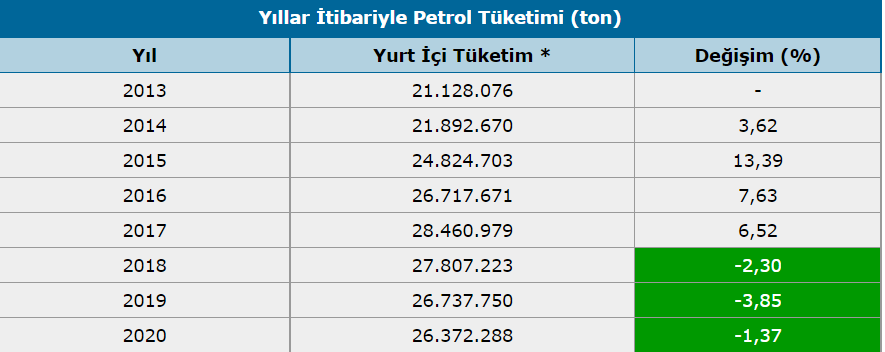
this data taken from the https://www.enerjiatlasi.com/akaryakit-tuketimi/

In [30]:
FuelConsumption = []
FuelConsumptionRate = []

for i in data["Year"]:
    if i == 2014:
        FuelConsumption.append(21892670)
        FuelConsumptionRate.append(3.62)
    elif i == 2015:
        FuelConsumption.append(24824703)
        FuelConsumptionRate.append(13.39)
    elif i == 2016:
        FuelConsumption.append(26717671)
        FuelConsumptionRate.append(7.63)    
    elif i == 2017:
        FuelConsumption.append(28460979)
        FuelConsumptionRate.append(6.52)
    elif i == 2018:
        FuelConsumption.append(27807223)
        FuelConsumptionRate.append(-2.30)
    elif i == 2019:
        FuelConsumption.append(26737750)
        FuelConsumptionRate.append(-3.85)
        
data["FuelConsumption"] = FuelConsumption
data["FuelConsumptionRate"] = FuelConsumptionRate
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1487732 non-null  object        
 1   CityCode             1487732 non-null  object        
 2   Customer             1487732 non-null  object        
 3   Date                 1487732 non-null  datetime64[ns]
 4   Litres               1379260 non-null  float64       
 5   Plant                1487732 non-null  object        
 6   Product              1487732 non-null  object        
 7   CRP                  1487732 non-null  float64       
 8   Year                 1487732 non-null  int64         
 9   Month                1487732 non-null  int64         
 10  Day                  1487732 non-null  int64         
 11  DayNames             1487732 non-null  object        
 12  USD/TRY              1487732 non-null  float64       
 1

#### 2.8 Season

In [31]:
season = []
for i in data["Month"]:
    if i == 1 or i == 2 or i == 12:
        season.append("Winter")
    elif i == 3 or i == 4 or i == 5:
        season.append("Spring")
    elif i == 6 or i == 7 or i == 8:
        season.append("Summer")
    elif i == 9 or i == 10 or i == 11:
        season.append("Fall")
data["Season"] = season
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1487732 non-null  object        
 1   CityCode             1487732 non-null  object        
 2   Customer             1487732 non-null  object        
 3   Date                 1487732 non-null  datetime64[ns]
 4   Litres               1379260 non-null  float64       
 5   Plant                1487732 non-null  object        
 6   Product              1487732 non-null  object        
 7   CRP                  1487732 non-null  float64       
 8   Year                 1487732 non-null  int64         
 9   Month                1487732 non-null  int64         
 10  Day                  1487732 non-null  int64         
 11  DayNames             1487732 non-null  object        
 12  USD/TRY              1487732 non-null  float64       
 1

## 3. Exploratory Data Analysis

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1487732 non-null  object        
 1   CityCode             1487732 non-null  object        
 2   Customer             1487732 non-null  object        
 3   Date                 1487732 non-null  datetime64[ns]
 4   Litres               1379260 non-null  float64       
 5   Plant                1487732 non-null  object        
 6   Product              1487732 non-null  object        
 7   CRP                  1487732 non-null  float64       
 8   Year                 1487732 non-null  int64         
 9   Month                1487732 non-null  int64         
 10  Day                  1487732 non-null  int64         
 11  DayNames             1487732 non-null  object        
 12  USD/TRY              1487732 non-null  float64       
 1

In [29]:
data.drop(["Date", "Year", "Day", "Month"], axis=1).describe()

Litres           CRP       USD/TRY    Population  VehiclesNumber  \
count  1.379260e+06  1.487732e+06  1.487732e+06  1.487732e+06    1.487732e+06   
mean   1.405520e+04  4.889838e+00  3.494281e+00  1.624957e+07    8.709524e+06   
std    1.093735e+04  9.306629e-01  1.148974e+00  7.128832e+06    2.236469e+06   
min    0.000000e+00  3.220000e+00  2.070000e+00  5.927630e+06    5.788505e+06   
25%    5.034000e+03  4.270000e+00  2.680000e+00  1.018278e+07    6.321508e+06   
50%    1.145900e+04  4.660000e+00  3.050000e+00  1.273239e+07    8.782462e+06   
75%    2.005000e+04  5.450000e+00  3.870000e+00  2.441542e+07    1.110294e+07   
max    2.732210e+05  7.380000e+00  6.890000e+00  2.565040e+07    1.186548e+07   

        MinumumWage    FuelAmount     TaxAmount      TaxRates  \
count  1.487732e+06  1.487732e+06  1.487732e+06  1.487732e+06   
mean   1.305893e+03  2.680332e+02  1.900313e+00  3.994165e+01   
std    3.213889e+02  4.743474e+01  3.329019e-01  8.365994e+00   
min    8.910000e+02  1.697100e+02  9.205000e-01  1.409600e+01   
25%    1.000540e+03  2.332300e+02  1.594500e+00  3.504400e+01   
50%    1.300990e+03  2.696900e+02  1.794500e+00  4.067600e+01   
75%    1.603000e+03  3.019400e+02  2.176500e+00  4.570200e+01   
max    2.020590e+03  4.040300e+02  2.376500e+00  5.926400e+01   

       FuelConsumption  FuelConsumptionRate  
count     1.487732e+06         1.487732e+06  
mean      2.607782e+07         4.990626e+00  
std       2.261108e+06         5.564953e+00  
min       2.189267e+07        -3.850000e+00  
25%       2.482470e+07        -2.300000e+00  
50%       2.671767e+07         6.520000e+00  
75%       2.780722e+07         7.630000e+00  
max       2.846098e+07         1.339000e+01

In [30]:
data[["Area", "CityCode", "Customer", "Plant", "Product", "DayNames", "Season"]].describe()

Area  CityCode  Customer    Plant  Product DayNames  \
count           1487732   1487732   1487732  1487732  1487732  1487732   
unique                7        76      1275       17        2        7   
top     Marmara Bölgesi       835  10049419     T314  Motorin   Monday   
freq             622365    357229      3828   271733   893177   340038   

         Season  
count   1487732  
unique        4  
top      Summer  
freq     413796

In [31]:
# i am going  to use the train data for EDA
visualize = data.copy()
df, df2 = divide_df(visualize)
dataVis = df.loc[(df["Litres"] > 0)]

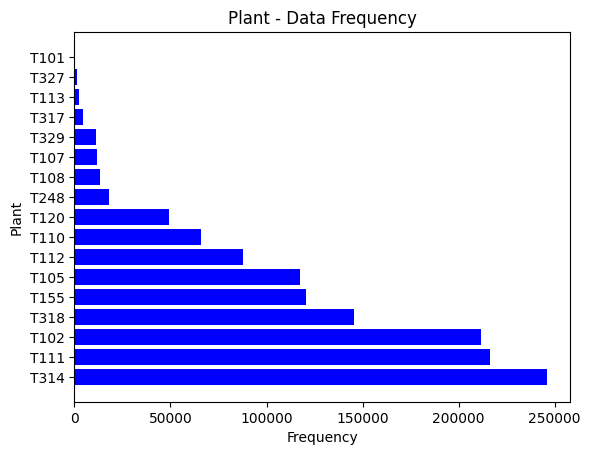

Number of Samples According to Plant 

T314    245875

T111    216375

T102    211762

T318    145495

T155    120736

T105    117305

T112     87503

T110     65959

T120     49434

T248     18164

T108     13513

T107     11883

T329     11211

T317      4610

T113      2279

T327      1263

T101       144

Name: Plant, dtype: int64


In [32]:
# Number of sample according to Plant
plt.figure()
plt.barh(dataVis["Plant"].value_counts().index, dataVis["Plant"].value_counts(), color = "b")
#plt.xticks(dataVis["Plant"].values)
plt.xlabel("Frequency")
plt.ylabel("Plant")
plt.title("Plant - Data Frequency")
plt.show()
print(f"Number of Samples According to Plant \n{dataVis['Plant'].value_counts()}")

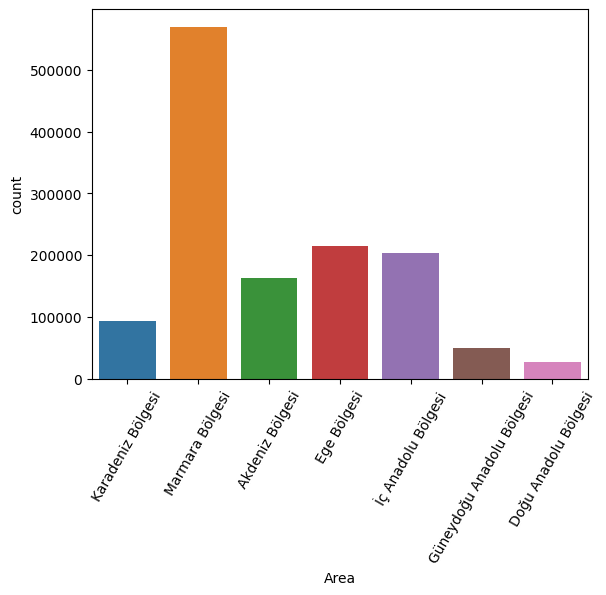

Number of samples According to Area 

Marmara Bölgesi              569284

Ege Bölgesi                  215709

İç Anadolu Bölgesi           203134

Akdeniz Bölgesi              163508

Karadeniz Bölgesi             93952

Güneydoğu Anadolu Bölgesi     50486

Doğu Anadolu Bölgesi          27438

Name: Area, dtype: int64


In [33]:
# Number of samples according to Area
sns.countplot(x="Area", data=dataVis)
plt.xticks(rotation = 60)
plt.show()
print(f"Number of samples According to Area \n{dataVis['Area'].value_counts()}")

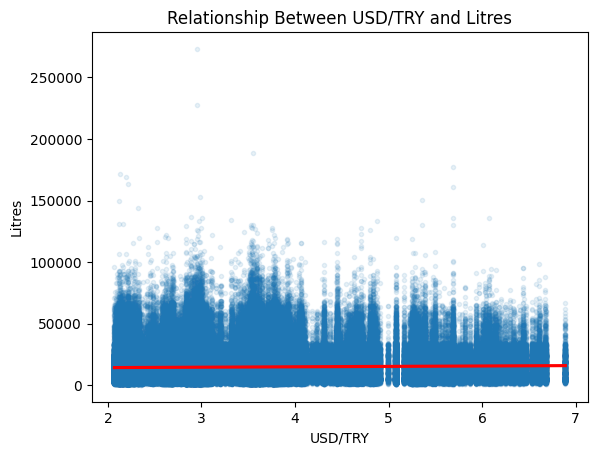

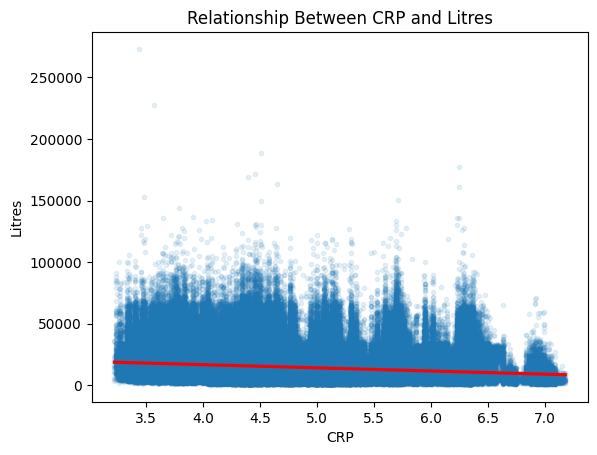

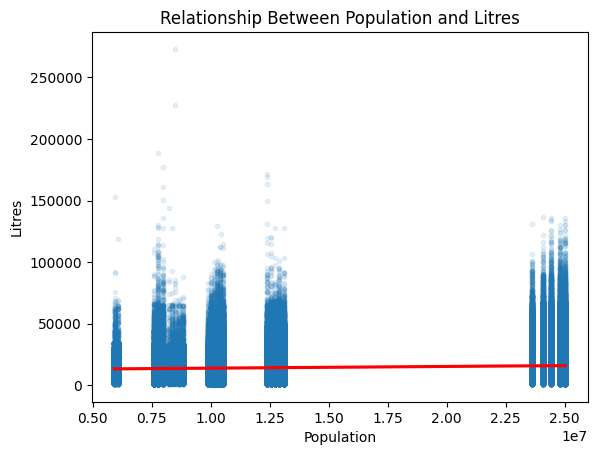

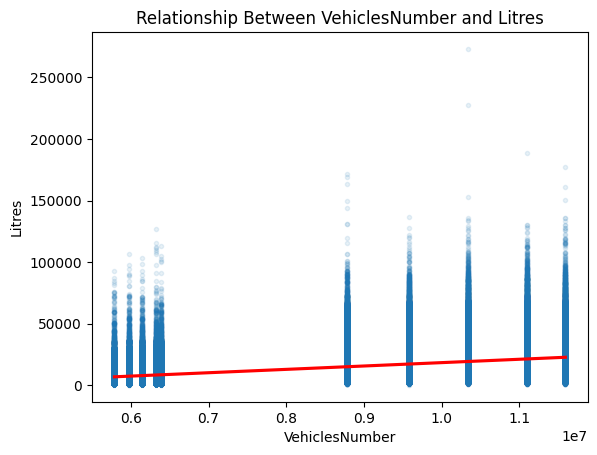

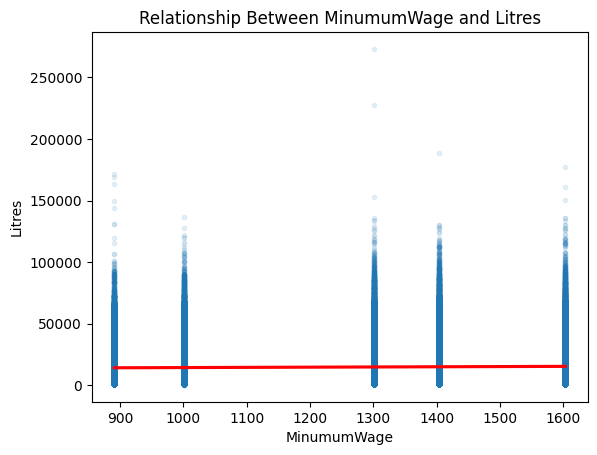

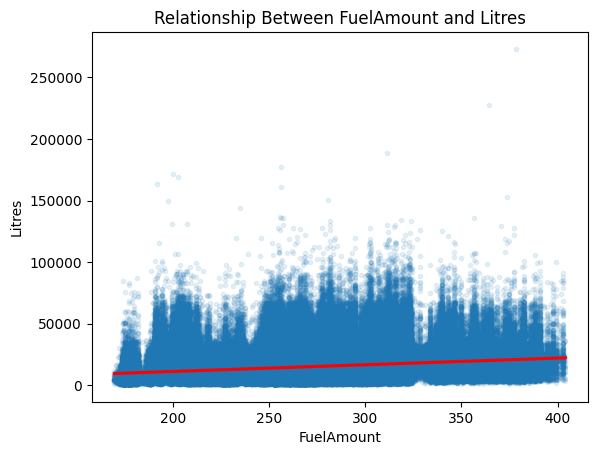

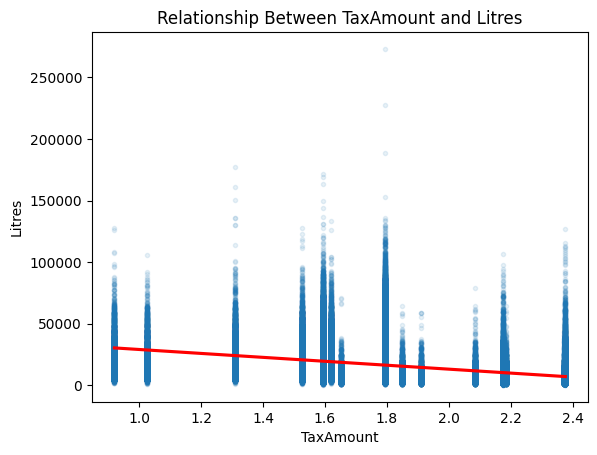

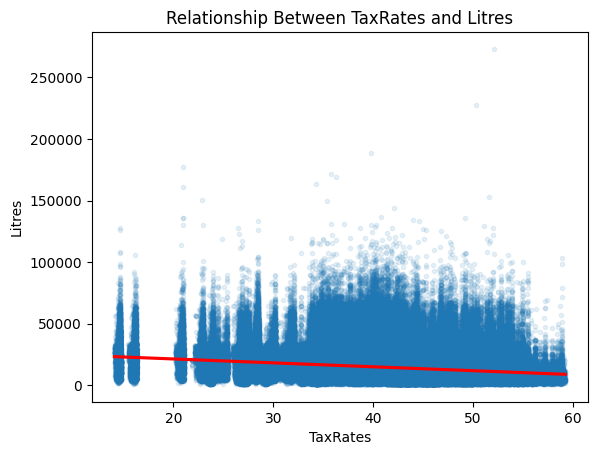

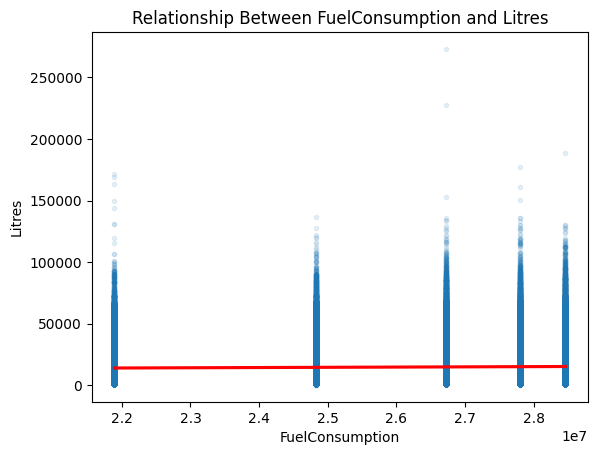

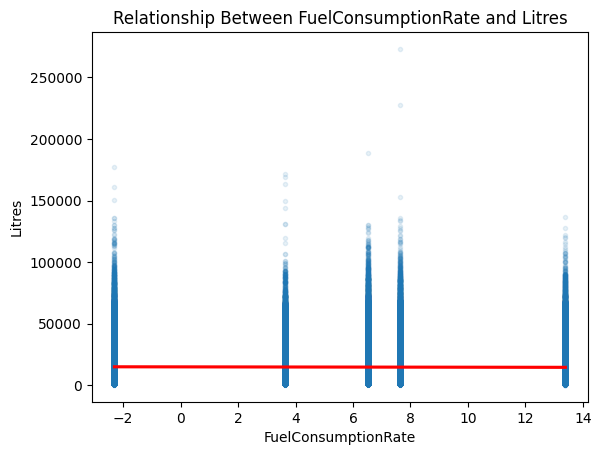

In [34]:
# check relation for some features
relation = ["USD/TRY", "CRP", "Population", "VehiclesNumber", "MinumumWage", "FuelAmount",
            "TaxAmount", "TaxRates", "FuelConsumption", "FuelConsumptionRate"]
for i in relation:
    sns.regplot(x=i, y='Litres', data=dataVis, marker=".", scatter_kws={'alpha':0.1}, line_kws={'color':"r"})
    plt.title(f'Relationship Between {i} and Litres')
    plt.show()

In [35]:
# we can check the correlation between features
data_all_corr = dataVis.corr().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
data_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
data_all_corr[data_all_corr['Feature 1'] == 'Litres']

Feature 1            Feature 2  Correlation Coefficient
0      Litres               Litres                 1.000000
40     Litres       VehiclesNumber                 0.556230
58     Litres           FuelAmount                 0.240578
73     Litres           Population                 0.092216
83     Litres      FuelConsumption                 0.039982
84     Litres          MinumumWage                 0.039255
86     Litres                 Year                 0.038911
94     Litres              USD/TRY                 0.031071
100    Litres                  Day                 0.014464
120    Litres                Month                -0.000346
146    Litres  FuelConsumptionRate                -0.013525
167    Litres                  CRP                -0.196685
171    Litres             TaxRates                -0.239594
180    Litres            TaxAmount                -0.494603

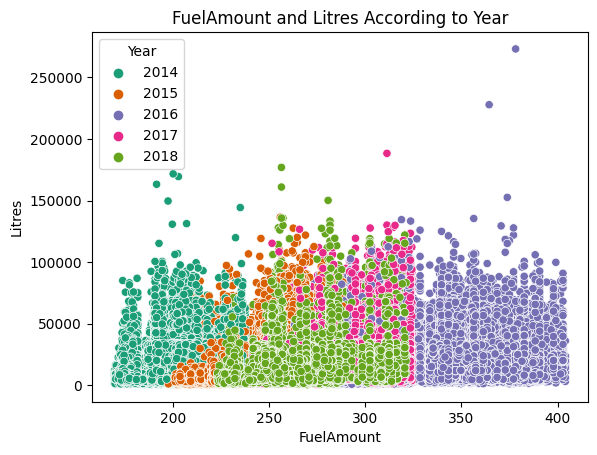

In [36]:
sns.scatterplot(x='FuelAmount', y='Litres', hue='Year', data=dataVis, palette = "Dark2")
plt.title('FuelAmount and Litres According to Year')
plt.show()

In [37]:
pd.crosstab(index=dataVis['Area'], columns=dataVis['Plant'])

Plant                      T101    T102    T105   T107   T108   T110   T111  \
Area                                                                          
Akdeniz Bölgesi               0       8      10  10375      0  58362  94753   
Doğu Anadolu Bölgesi          0       6      20      0      0      0  16804   
Ege Bölgesi                   7    6455      74   1472      0   7285      0   
Güneydoğu Anadolu Bölgesi     0       2       0      0      0      0  48463   
Karadeniz Bölgesi             5   29664    4279      0      0      0      2   
Marmara Bölgesi             132  161778       0      0  13513      0      0   
İç Anadolu Bölgesi            0   13849  112922     36      0    312  56353   

Plant                       T112  T113   T120    T155   T248    T314  T317  \
Area                                                                         
Akdeniz Bölgesi                0     0      0       0      0       0     0   
Doğu Anadolu Bölgesi           0  1309   2671       0   4905       0  1511   
Ege Bölgesi                74593     0      0     638      0       0     0   
Güneydoğu Anadolu Bölgesi      0   970      0       0      0       0     0   
Karadeniz Bölgesi              0     0  40784    2857  13259       0  3099   
Marmara Bölgesi            12896     0      0  114926      0  245875     0   
İç Anadolu Bölgesi            14     0   5979    2315      0       0     0   

Plant                        T318  T327   T329  
Area                                            
Akdeniz Bölgesi                 0     0      0  
Doğu Anadolu Bölgesi            0   212      0  
Ege Bölgesi                125185     0      0  
Güneydoğu Anadolu Bölgesi       0  1051      0  
Karadeniz Bölgesi               0     0      3  
Marmara Bölgesi             20164     0      0  
İç Anadolu Bölgesi            146     0  11208

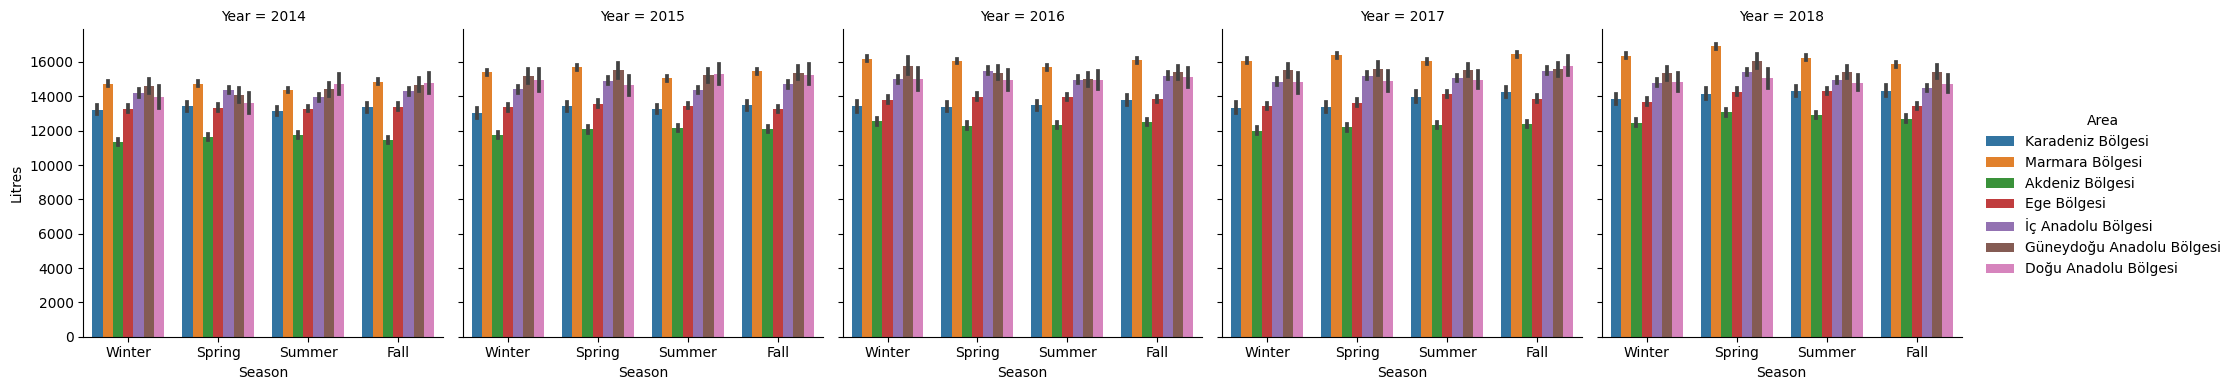

In [38]:
sns.catplot(x="Season", y="Litres",  hue="Area", col="Year",
            data=dataVis, kind="bar", height=4)
plt.show()

### Yearly  Analysis

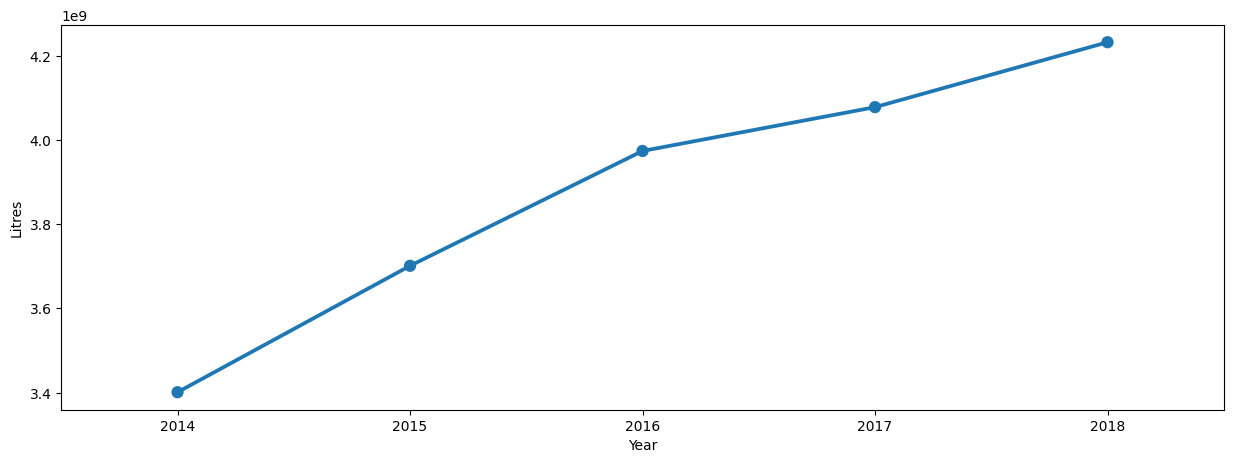

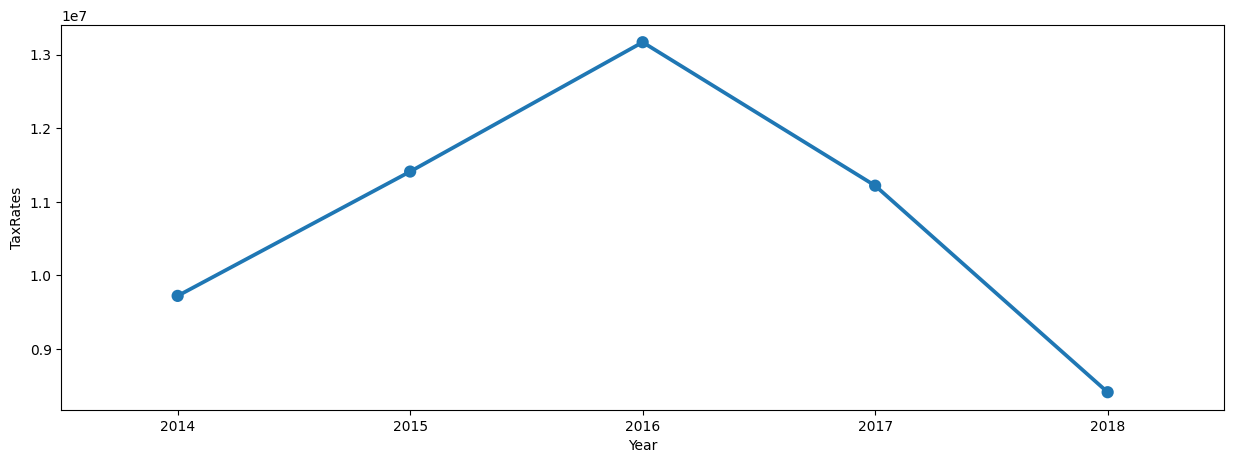

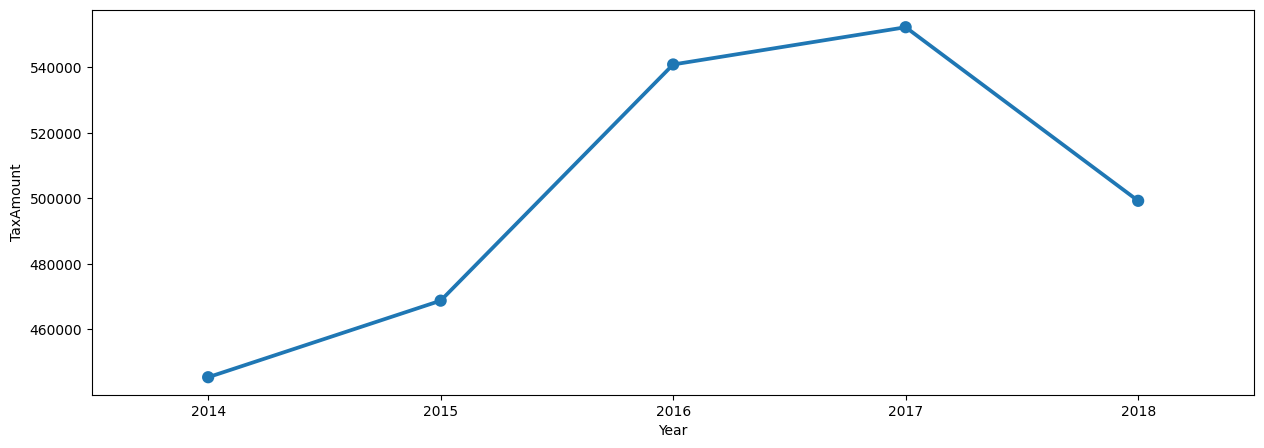

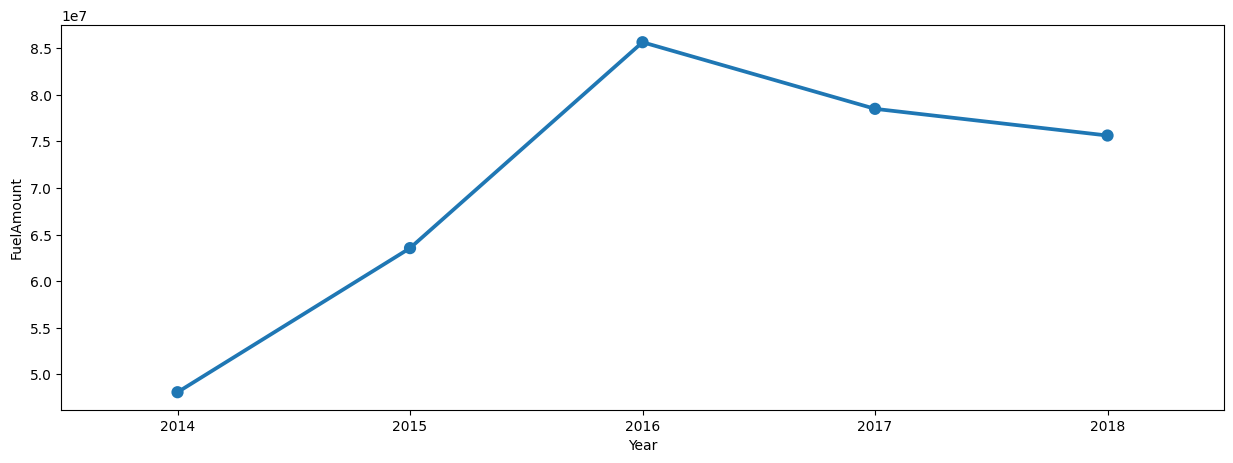

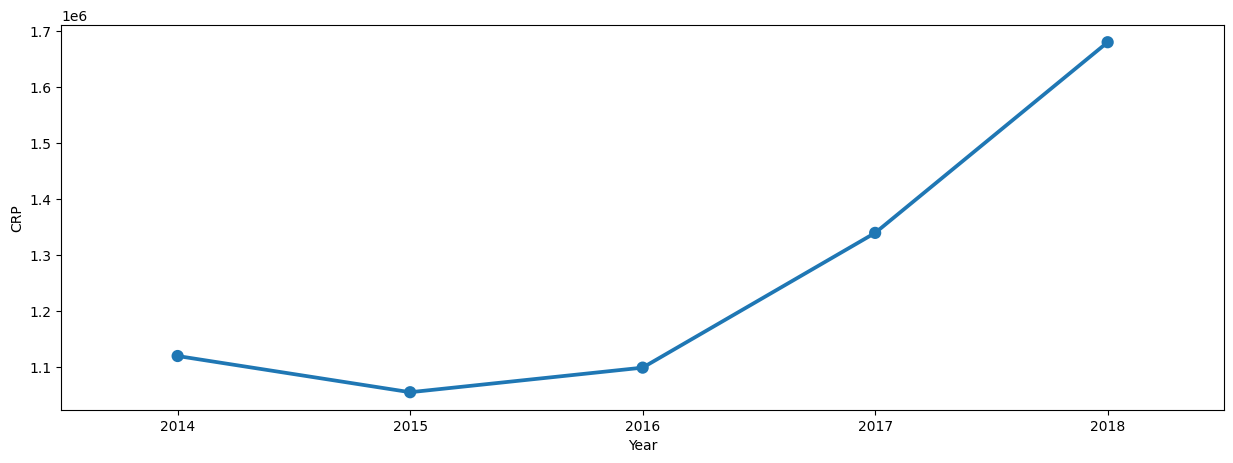

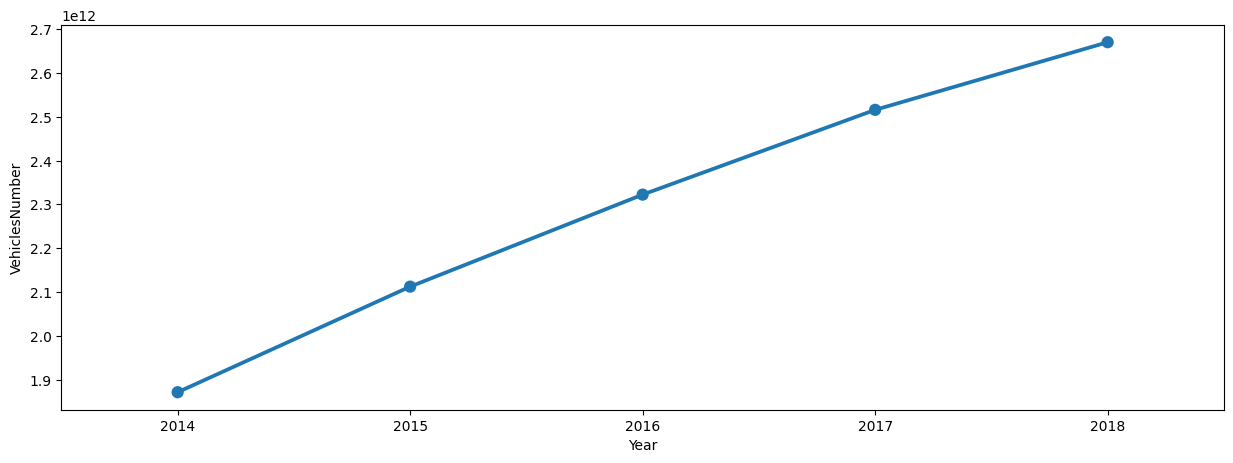

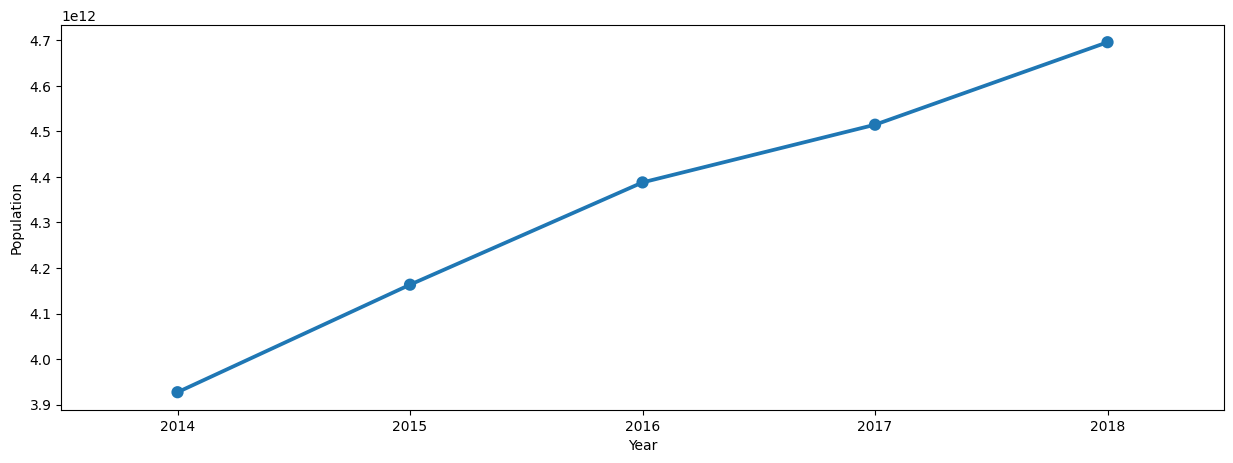

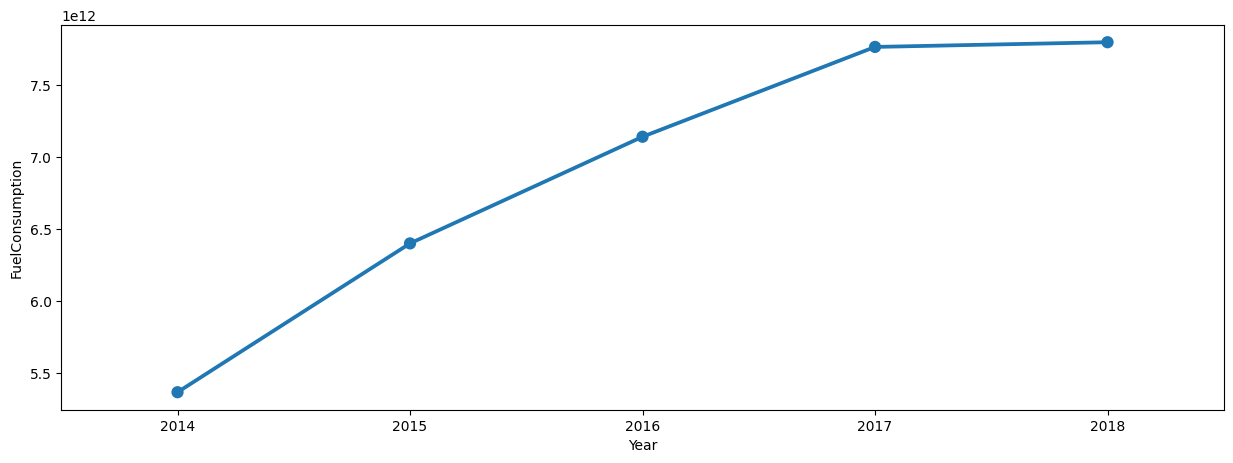

In [39]:
compounds = ["Litres", "TaxRates", "TaxAmount", "FuelAmount", "CRP", 
             "VehiclesNumber", "Population", "FuelConsumption"]
for i in compounds:    
    df = dataVis[[i, 'Year']].groupby(["Year"]).sum().reset_index().sort_values(by='Year', ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Year', y=i, data=df)

### Monthly and Yearly Analysis

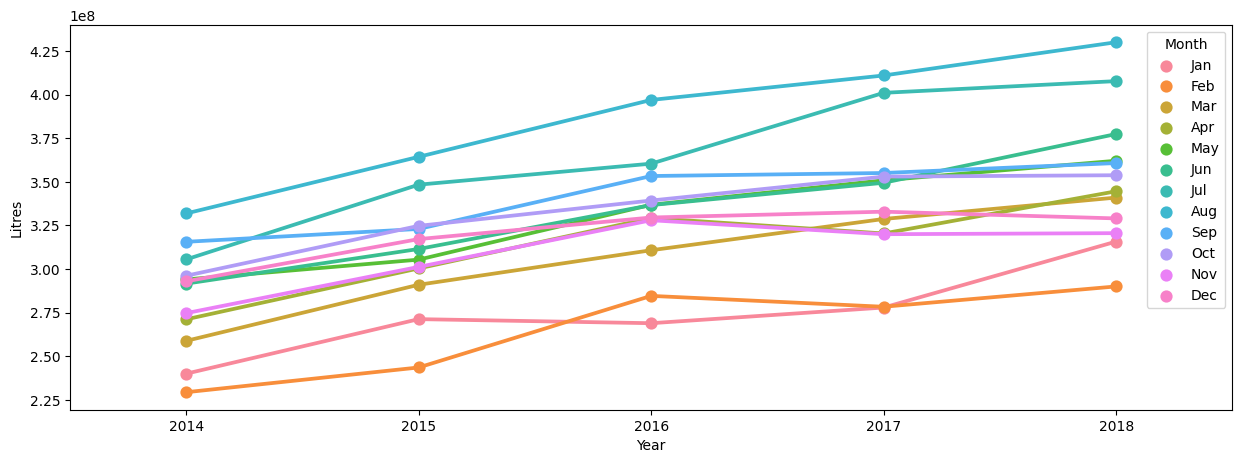

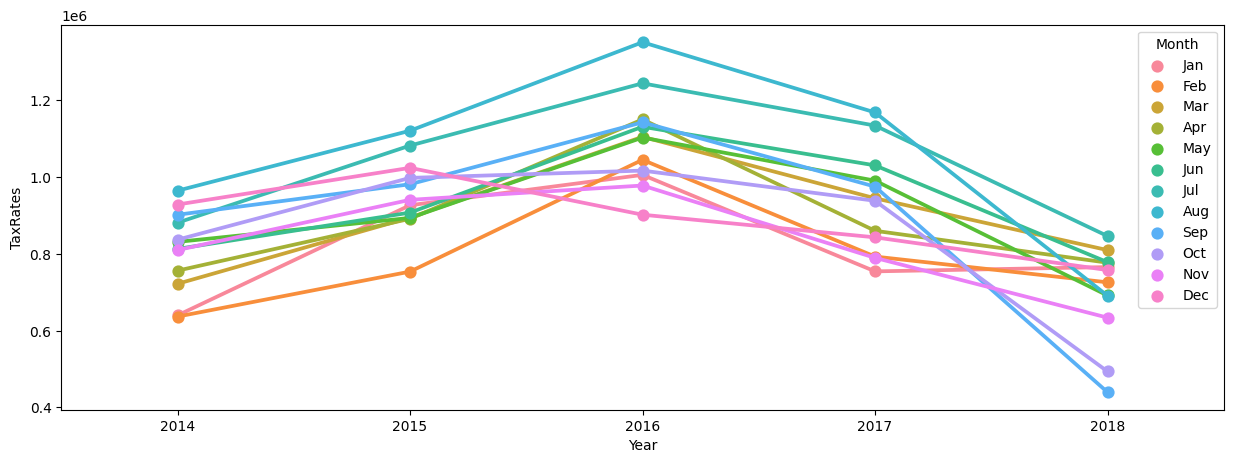

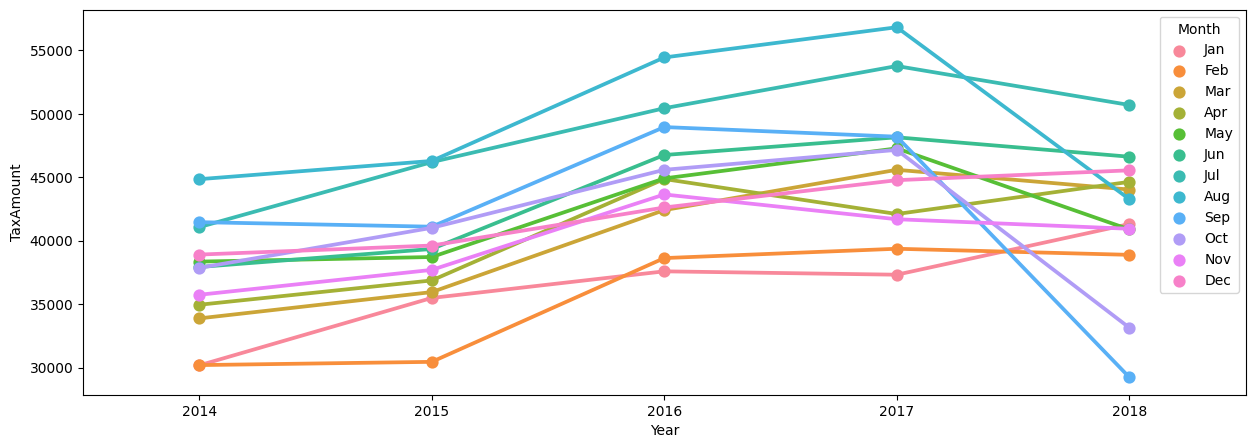

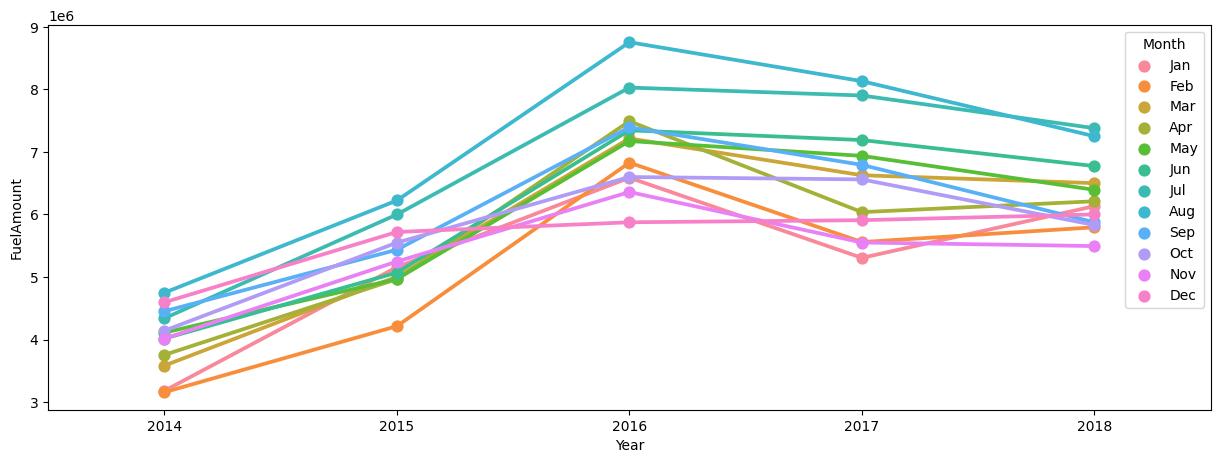

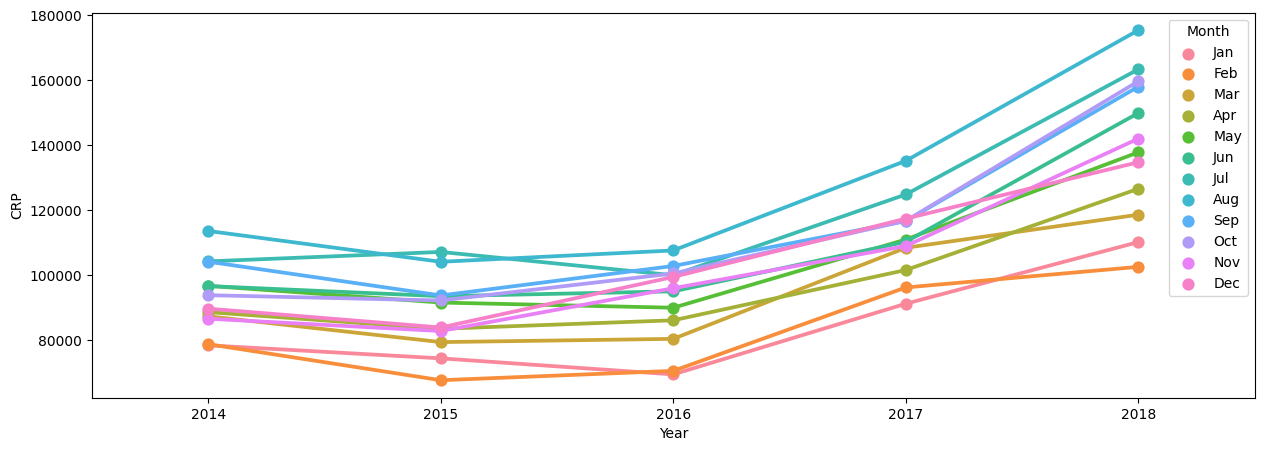

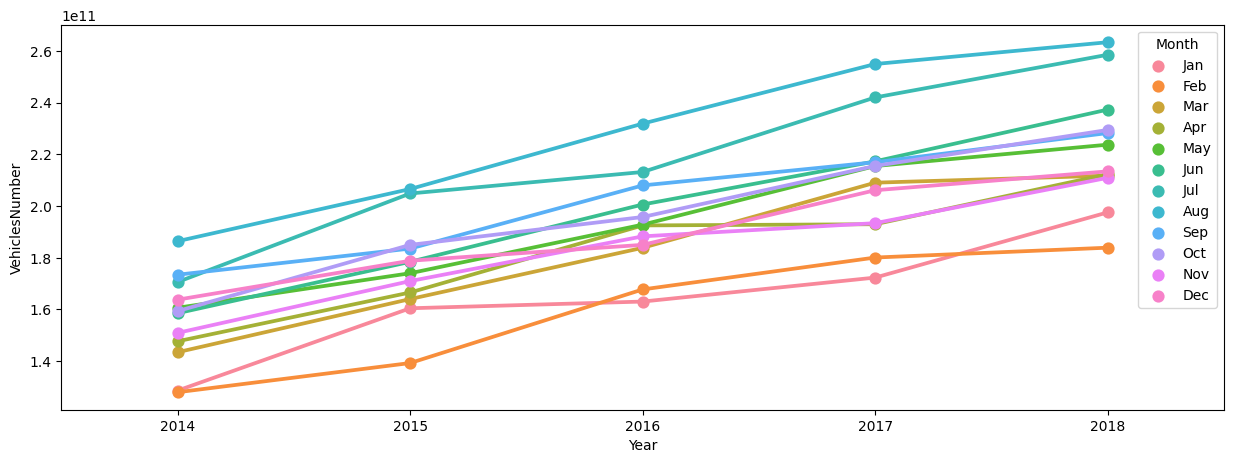

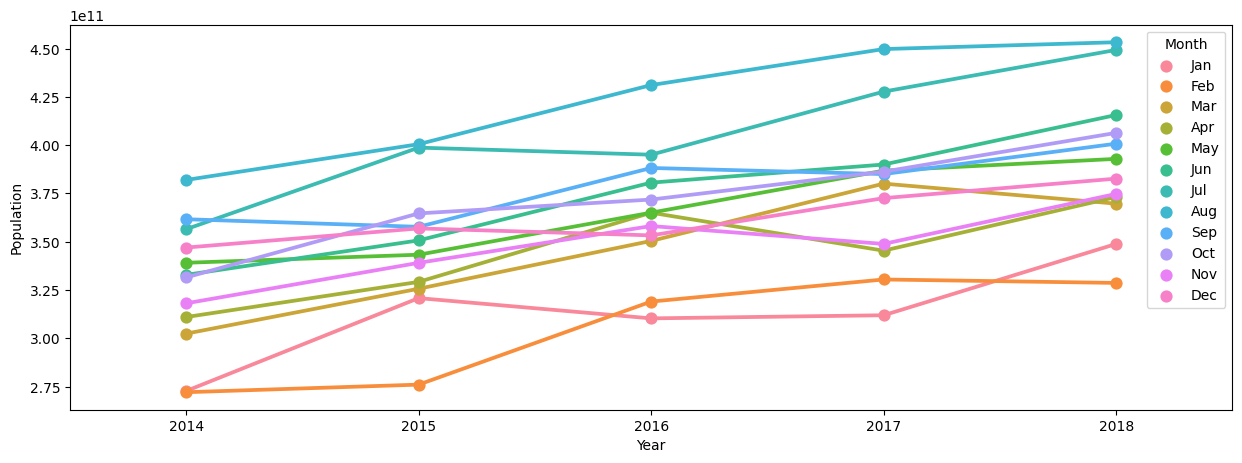

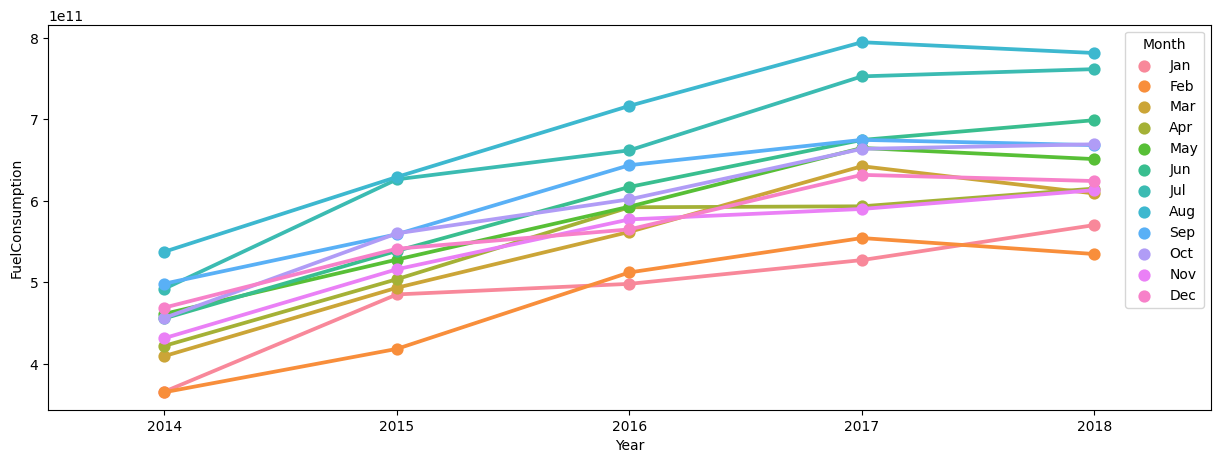

In [40]:
for i in compounds:
    temp_data = dataVis.copy()
    temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                           'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    df = temp_data[[i, 'Month', 'Year',]].groupby(["Year",
                                                    "Month"]).sum().reset_index().sort_values(by=['Year',
                                                                                                   'Month'], ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Year', y=i, data=df, hue='Month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                                  'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

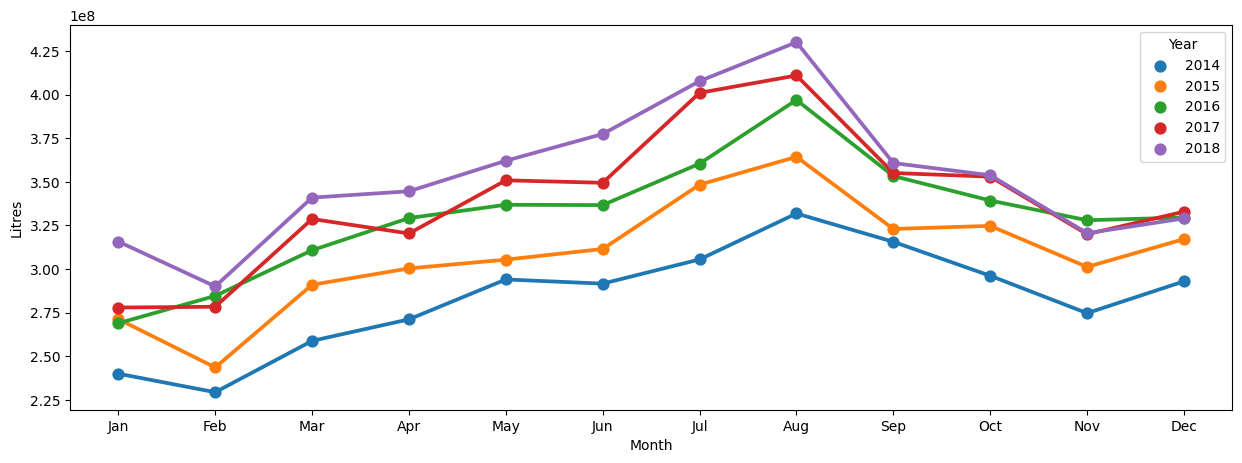

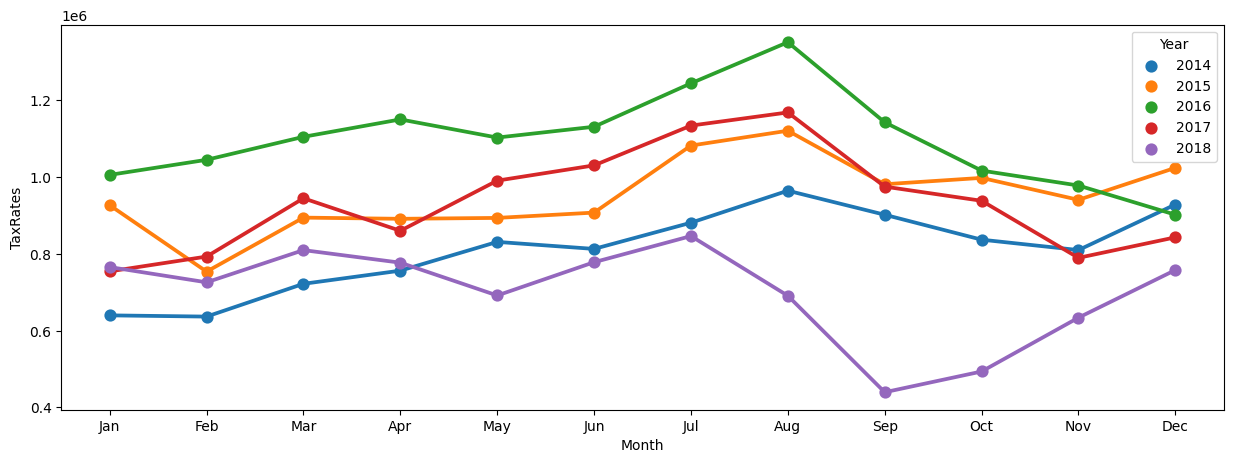

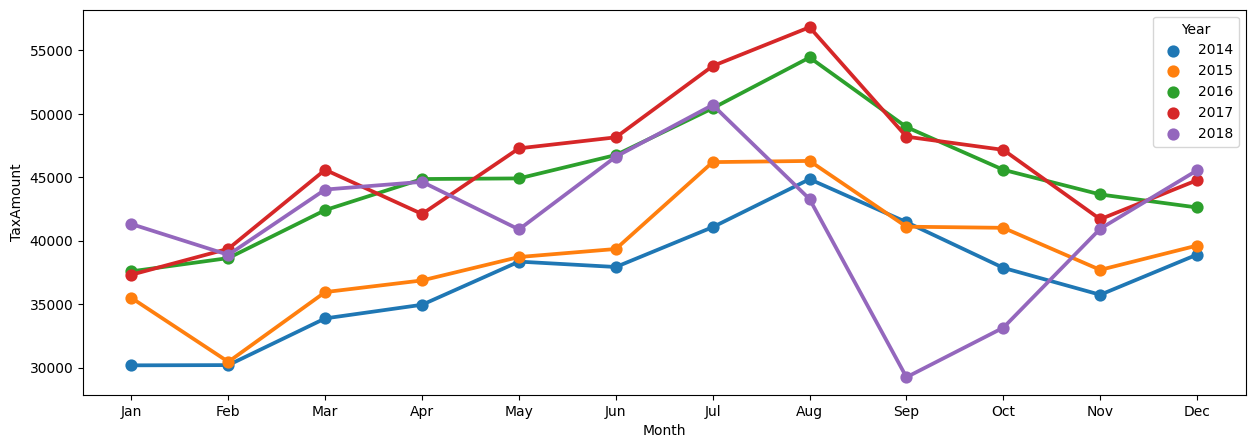

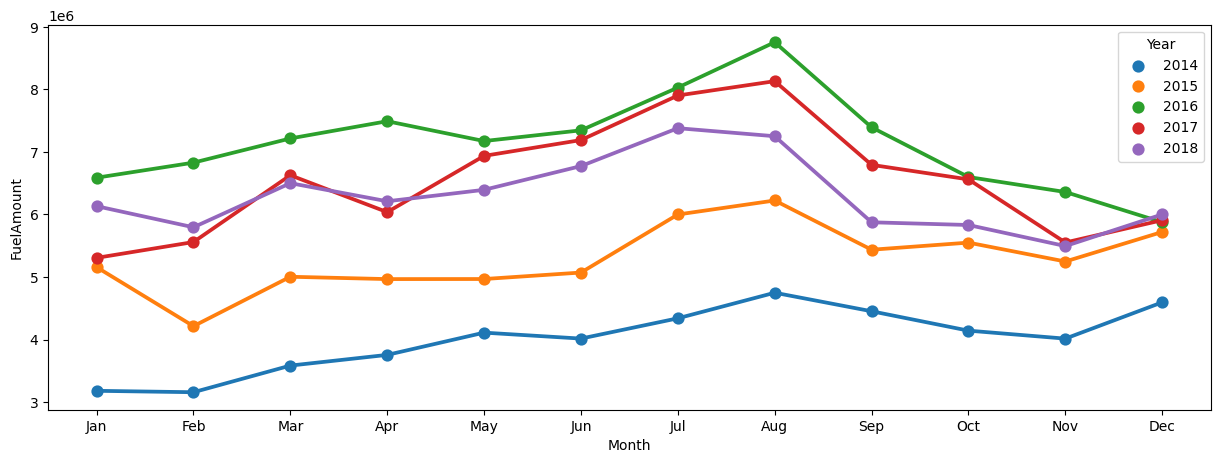

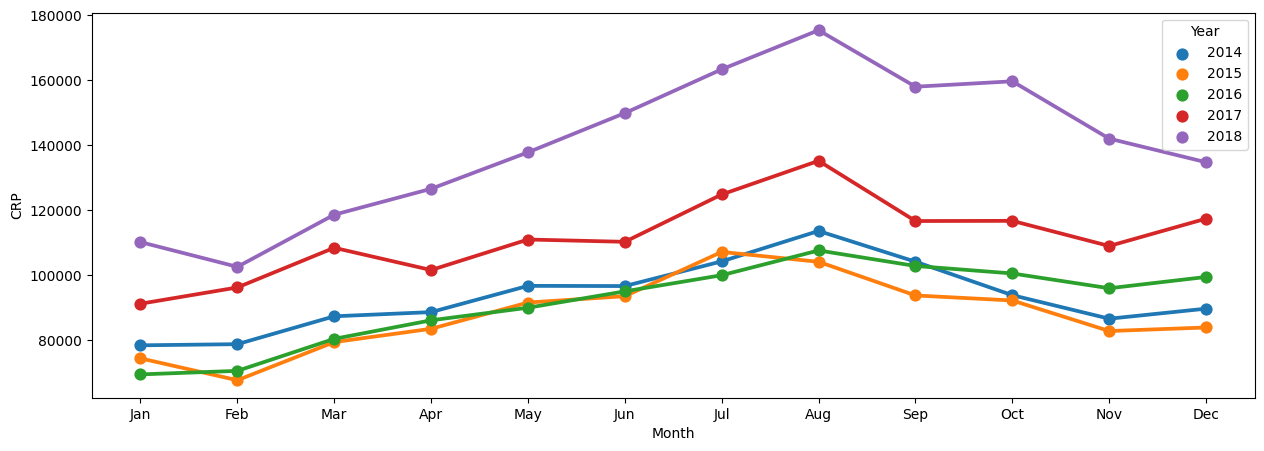

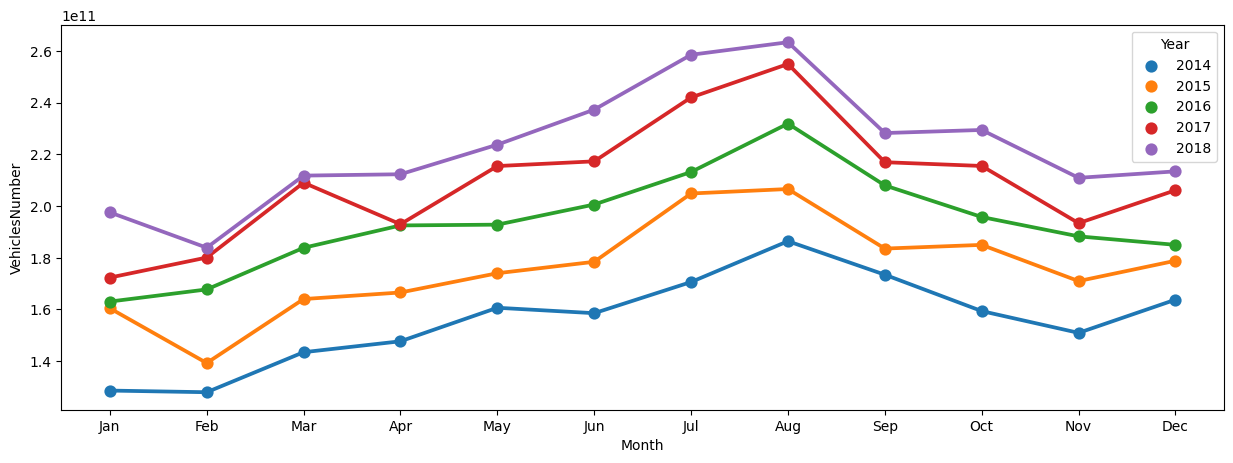

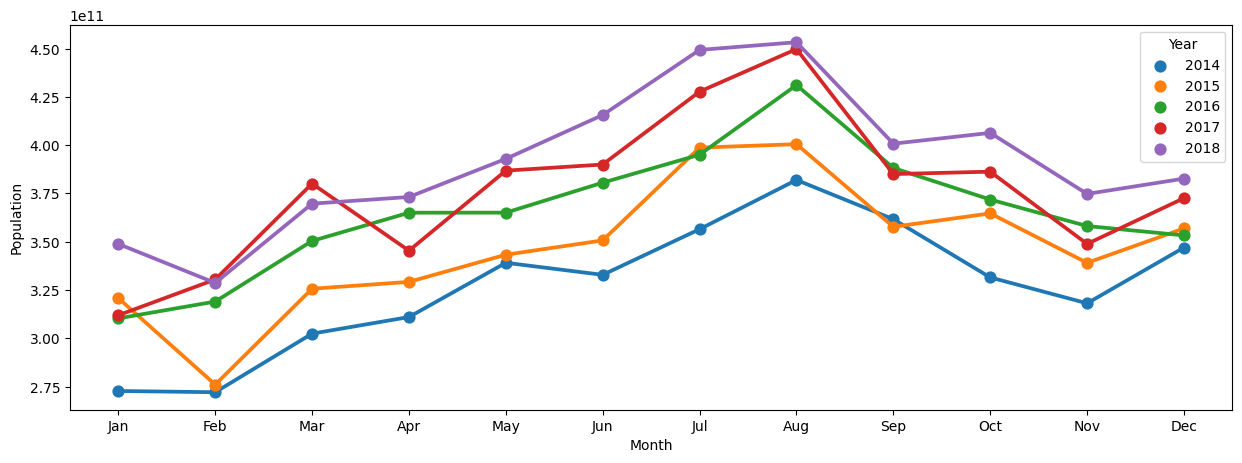

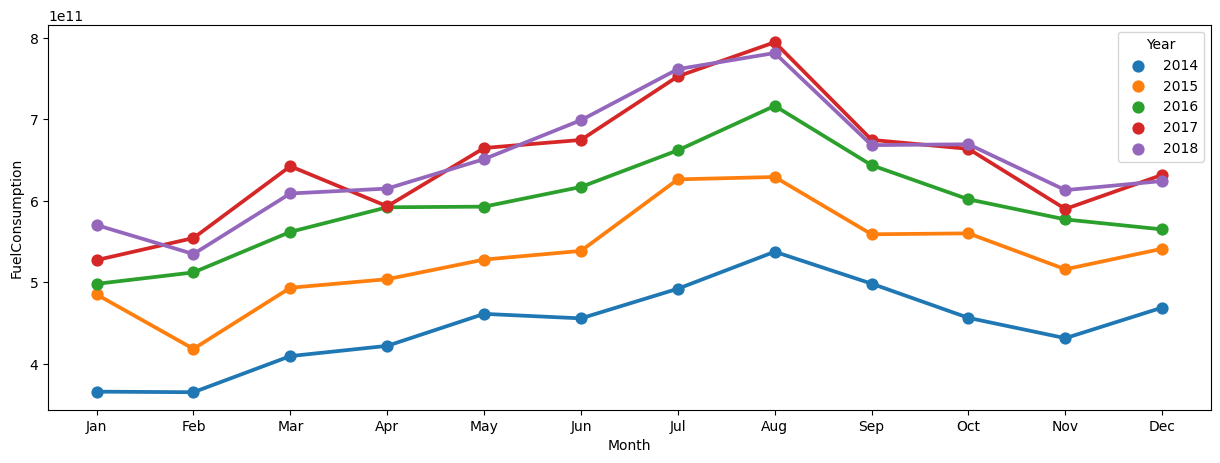

In [41]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
for i in compounds:    
    temp_data = dataVis.copy()
    temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                               'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    df = temp_data[[i, 'Month', 'Year']].groupby(["Year",
                                                  "Month"]).sum().reset_index().sort_values(by=['Year', 
                                                                                                 'Month'], ascending=True)
    df = df.iloc[df['Month'].map(custom_dict).argsort()]
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Month', y=i, data=df, hue="Year")

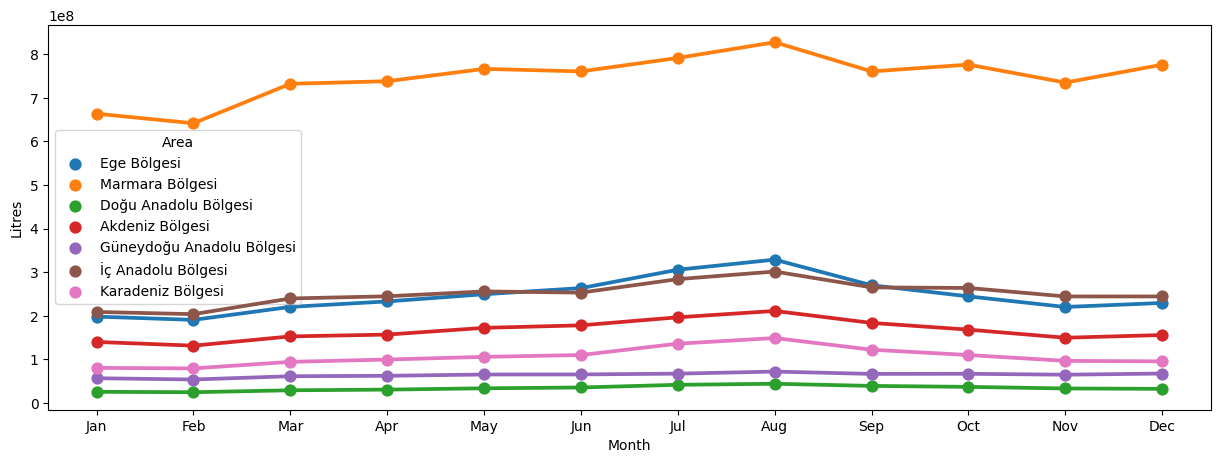

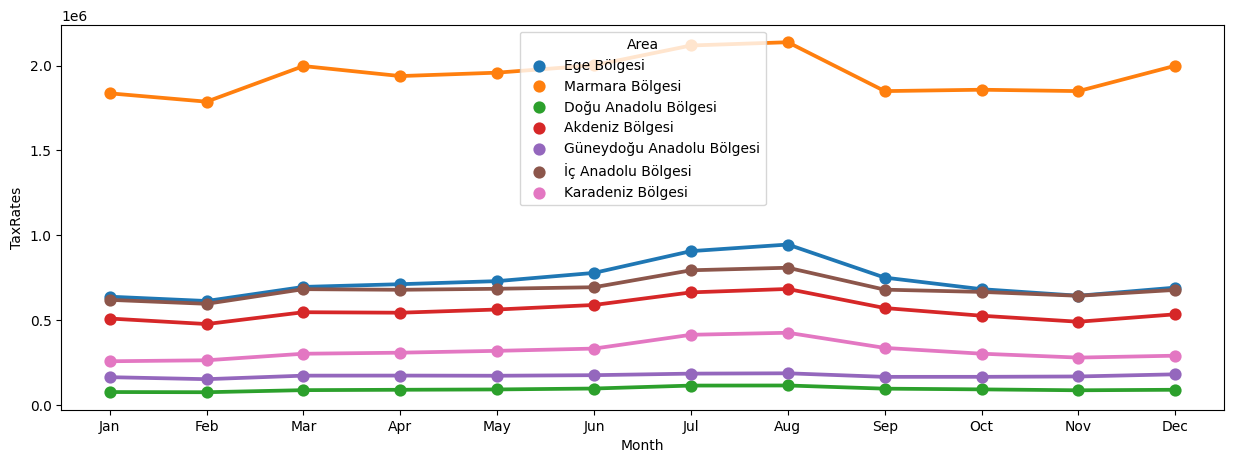

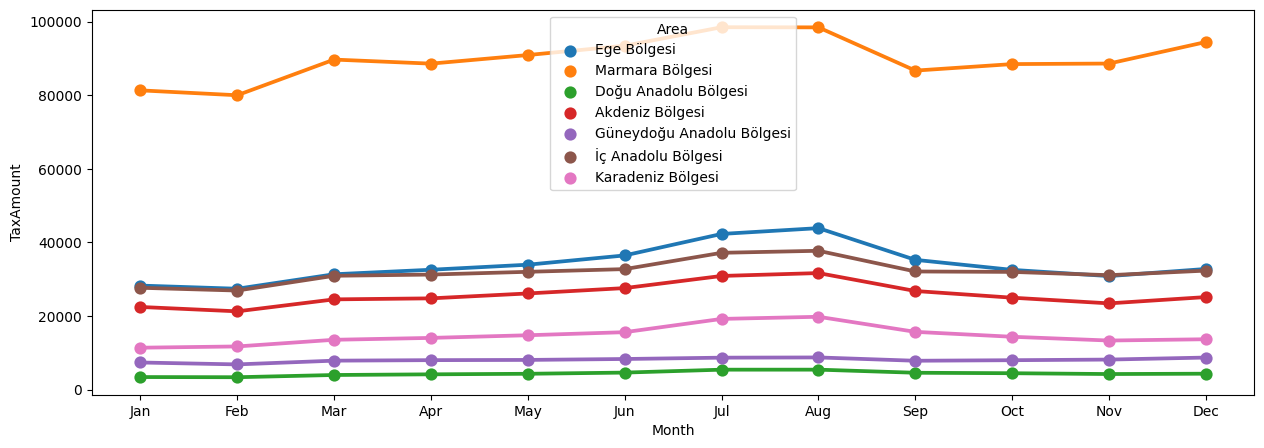

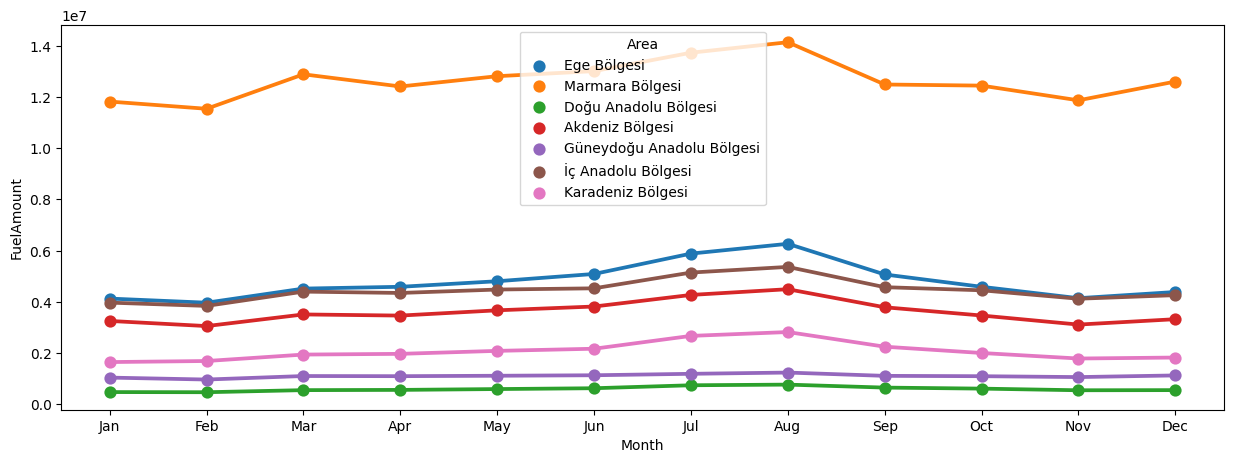

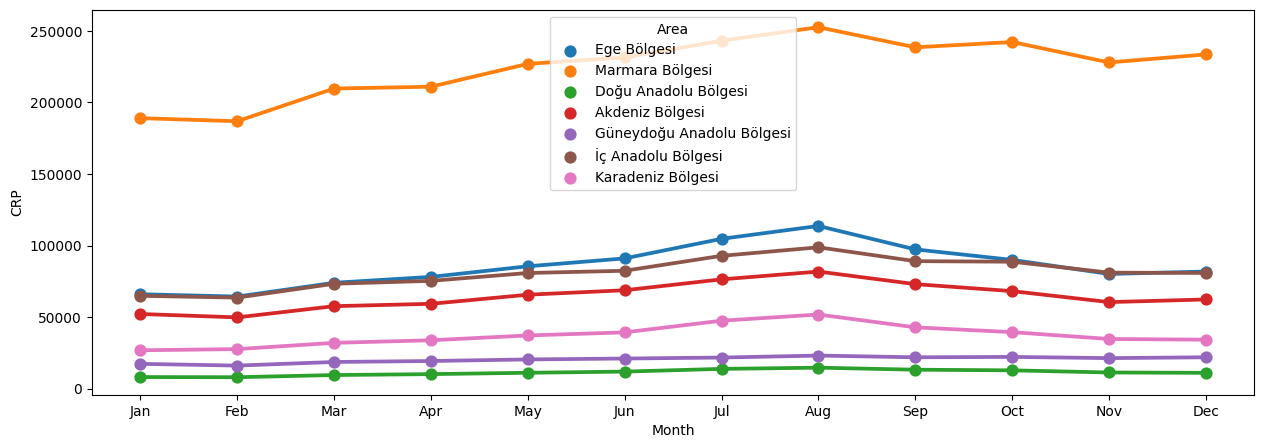

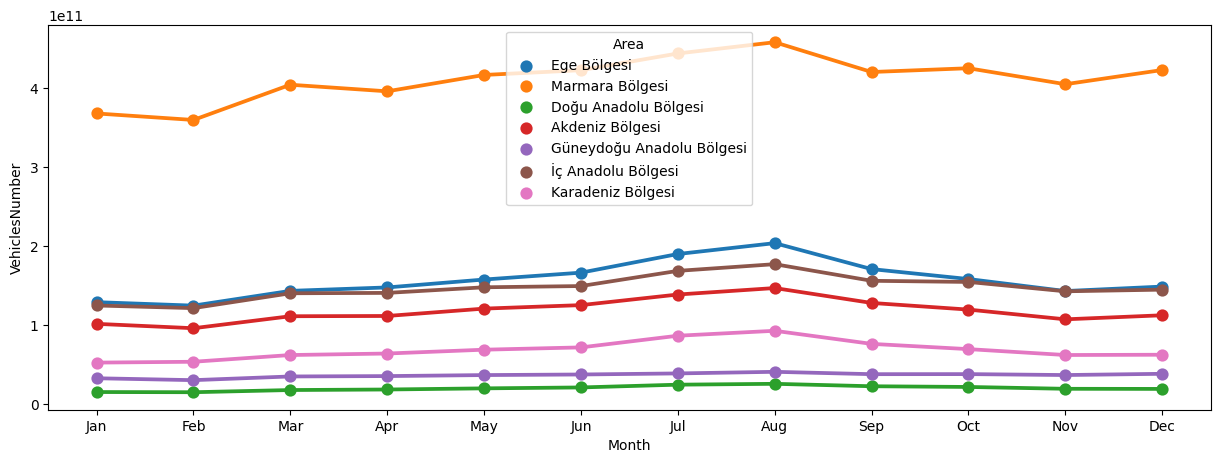

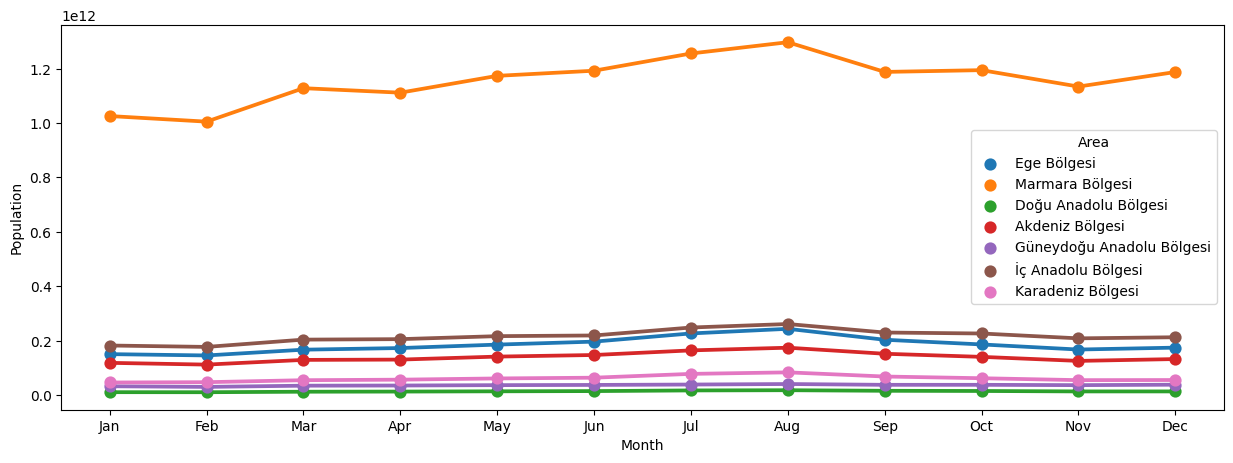

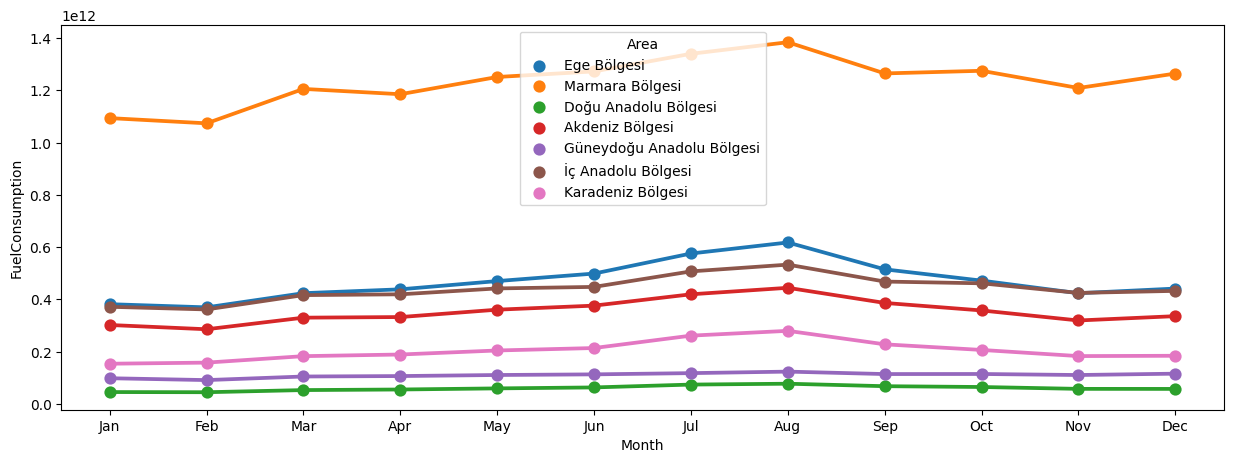

In [42]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
for i in compounds:    
    temp_data = dataVis.copy()
    temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                               'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    df = temp_data[[i, 'Month', 'Area']].groupby(["Area",
                                                  "Month"]).sum().reset_index().sort_values(by=['Area', 
                                                                                                 'Month'], ascending=True)
    df = df.iloc[df['Month'].map(custom_dict).argsort()]
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Month', y=i, data=df, hue="Area")

### Weekly Analysis

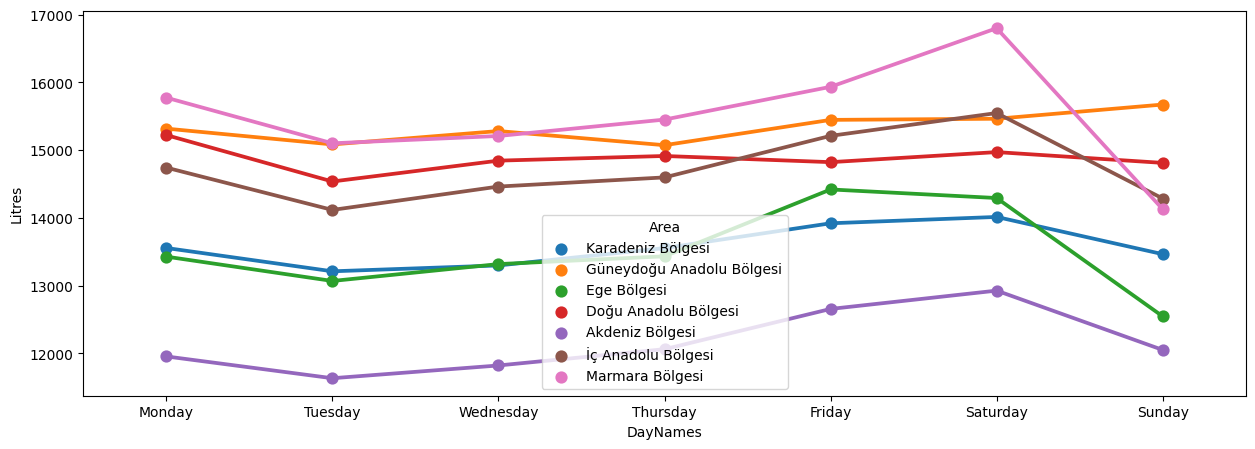

In [43]:
custom_day = {'Monday':0, 'Tuesday':1, 'Wednesday':2,
              'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

df = dataVis[["Litres", 'DayNames', 'Area']].groupby(["Area", "DayNames"]).mean().reset_index().sort_values(by=['Area', 'DayNames'], ascending=True)
df = df.iloc[df['DayNames'].map(custom_day).argsort()]
f,ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='DayNames', y="Litres", data=df, hue="Area")
plt.show()

### Season Based Analysis

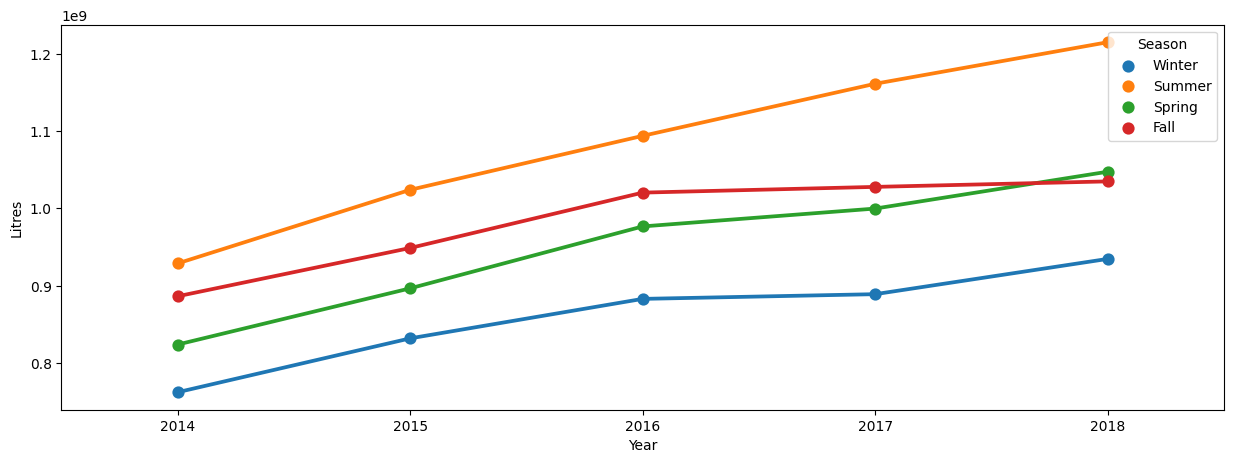

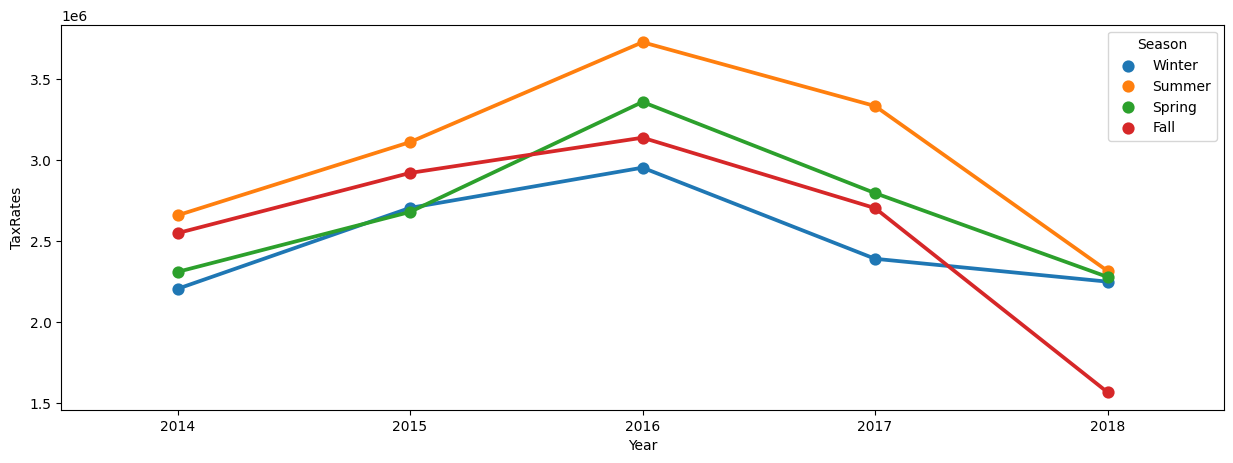

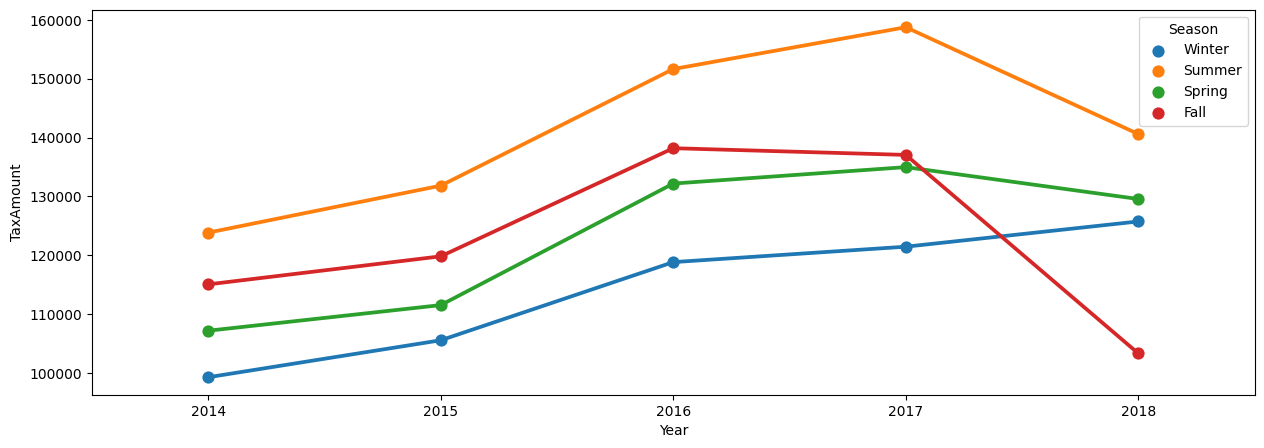

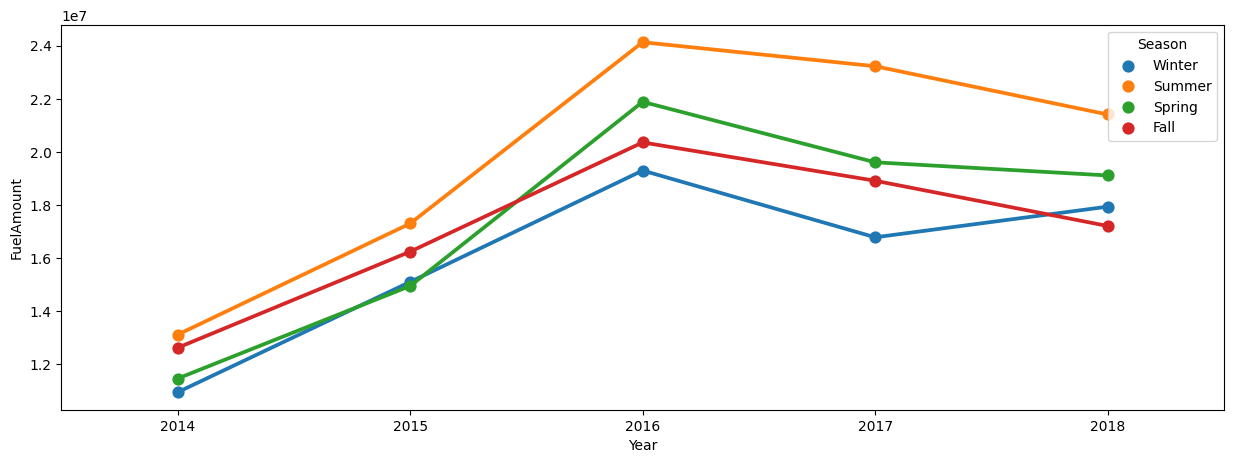

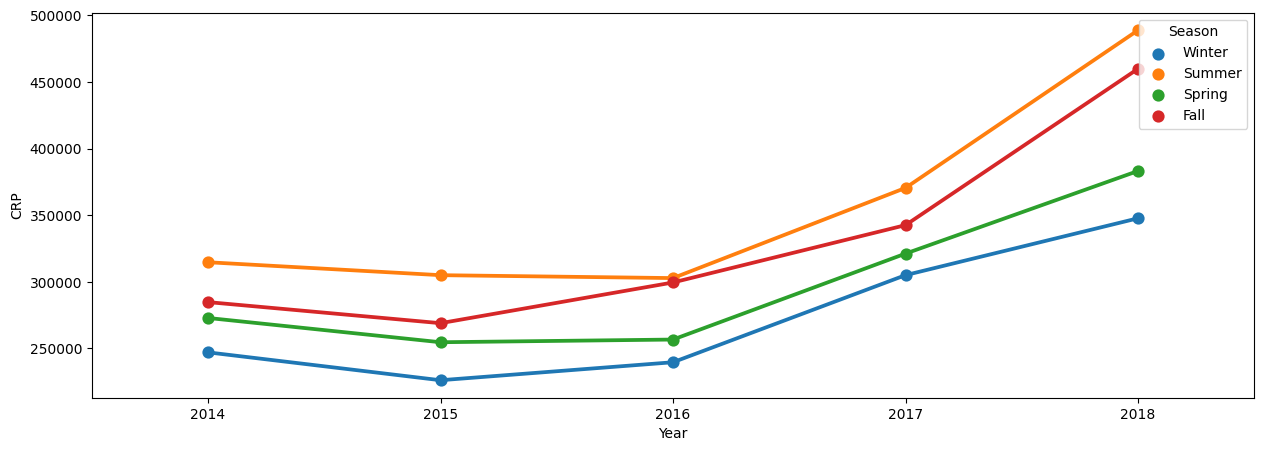

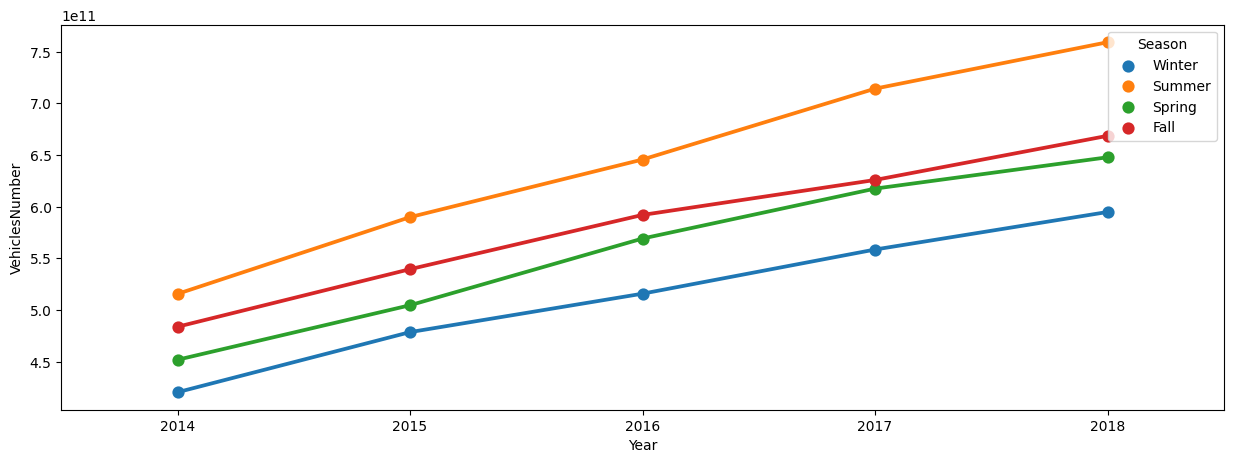

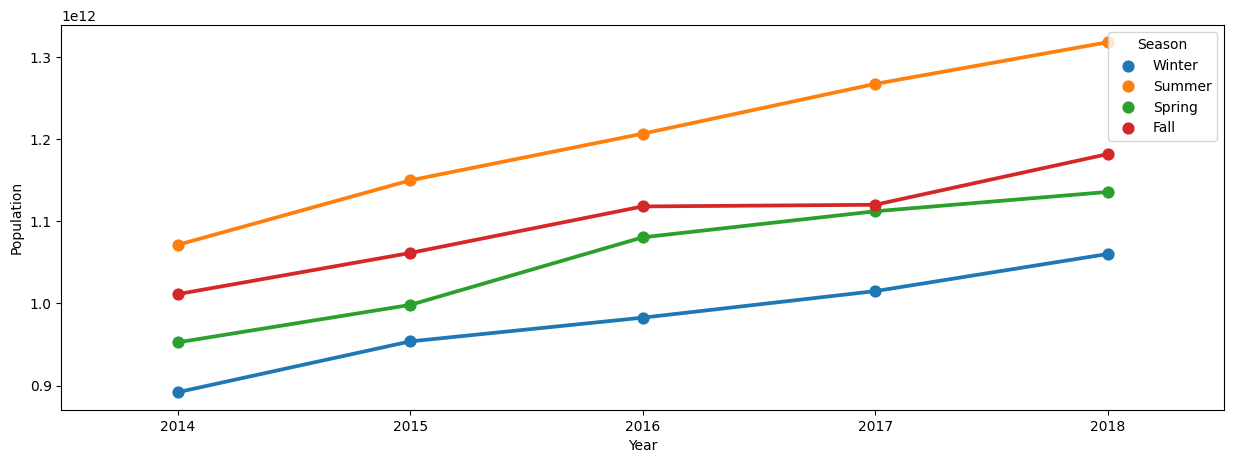

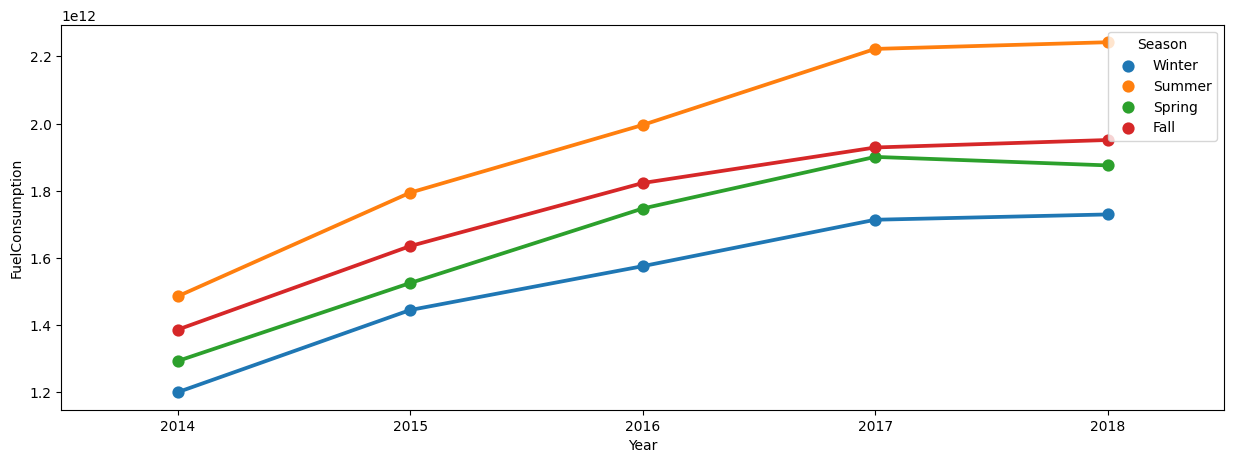

In [44]:
for i in compounds:  
    df = dataVis[[i, 'Year', 'Season']].groupby(["Year",
                                                 "Season"]).sum().reset_index().sort_values(by=['Season',
                                                                                                'Year'], ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Year', y=i, data=df, hue="Season")
    plt.show()

## 4. Preprocessing

In [73]:
deneme = data.copy()
deneme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1487732 non-null  object        
 1   CityCode             1487732 non-null  object        
 2   Customer             1487732 non-null  object        
 3   Date                 1487732 non-null  datetime64[ns]
 4   Litres               1379260 non-null  float64       
 5   Plant                1487732 non-null  object        
 6   Product              1487732 non-null  object        
 7   CRP                  1487732 non-null  float64       
 8   Year                 1487732 non-null  int64         
 9   Month                1487732 non-null  int64         
 10  Day                  1487732 non-null  int64         
 11  DayNames             1487732 non-null  object        
 12  USD/TRY              1487732 non-null  float64       
 1

In [38]:
# drop some columns and reduce memory
deneme.drop(["Date", "Year", "Day", "Customer", "DayNames"], axis=1, inplace=True)
deneme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Area                 1487732 non-null  object 
 1   CityCode             1487732 non-null  object 
 2   Litres               1379260 non-null  float64
 3   Plant                1487732 non-null  object 
 4   Product              1487732 non-null  object 
 5   CRP                  1487732 non-null  float64
 6   Month                1487732 non-null  int64  
 7   USD/TRY              1487732 non-null  float64
 8   Population           1487732 non-null  int64  
 9   VehiclesNumber       1487732 non-null  int64  
 10  MinumumWage          1487732 non-null  float64
 11  FuelAmount           1487732 non-null  float64
 12  TaxAmount            1487732 non-null  float64
 13  TaxRates             1487732 non-null  float64
 14  FuelConsumption      1487732 non-null  int64  
 15

In [74]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# define a function for label encoding
def labelEncoder(labelColumn):
    labelValues = labelColumn
    unique_labels = labelColumn.unique()
    le = LabelEncoder()
    labelColumn = le.fit_transform(labelColumn)
    print('Encoding Approach:')
    for i, j in zip(unique_labels, labelColumn[np.sort(np.unique(labelColumn, return_index=True)[1])]): 
        print(f'{i}  ==>  {j}')
    return labelColumn

categorical_variables = ["Product", "CityCode", "Area", "Plant", "Season"]
for i in categorical_variables:
    print(f"For {i} column ")
    deneme[f"{i}"] = labelEncoder(deneme[f"{i}"])
    print("**********************************")
    
    
# use OneHotEncoder for other categorical features
#deneme = pd.get_dummies(deneme, columns=["Area", "Plant", "Season"])

deneme.head(3)

For Product column 
Encoding Approach:
Benzin  ==>  0
Motorin  ==>  1
**********************************
For CityCode column 
Encoding Approach:
883  ==>  61
966  ==>  72
589  ==>  36
523  ==>  29
941  ==>  68
915  ==>  66
812  ==>  56
936  ==>  67
647  ==>  40
466  ==>  24
835  ==>  59
949  ==>  70
789  ==>  53
574  ==>  34
434  ==>  23
834  ==>  58
288  ==>  13
913  ==>  65
667  ==>  44
367  ==>  18
126  ==>  2
987  ==>  74
474  ==>  25
818  ==>  57
884  ==>  62
570  ==>  33
354  ==>  17
810  ==>  55
634  ==>  39
990  ==>  75
565  ==>  32
256  ==>  11
429  ==>  21
575  ==>  35
976  ==>  73
774  ==>  52
321  ==>  16
320  ==>  15
676  ==>  46
902  ==>  64
125  ==>  1
682  ==>  47
722  ==>  49
621  ==>  38
203  ==>  8
476  ==>  27
172  ==>  4
674  ==>  45
194  ==>  6
532  ==>  31
650  ==>  41
658  ==>  43
287  ==>  12
757  ==>  51
693  ==>  48
793  ==>  54
750  ==>  50
218  ==>  9
530  ==>  30
893  ==>  63
865  ==>  60
475  ==>  26
401  ==>  19
174  ==>  5
611  ==>  37
657  ==>  42
947 

Area  CityCode  Customer       Date  Litres  Plant  Product   CRP  Year  \
0     4        61  10048261 2014-01-01     0.0      1        0  4.98  2014   
1     4        61  10048261 2014-01-01     0.0     10        0  4.98  2014   
2     4        61  10048261 2014-01-01     0.0      1        1  4.58  2014   

   Month  ...  USD/TRY Population  VehiclesNumber  MinumumWage  FuelAmount  \
0      1  ...     2.14    7597894         5788505        891.0      178.92   
1      1  ...     2.14    7597894         5788505        891.0      178.92   
2      1  ...     2.14    7597894         8782462        891.0      194.54   

   TaxAmount  TaxRates  FuelConsumption  FuelConsumptionRate  Season  
0     2.1765    43.705         21892670                 3.62       3  
1     2.1765    43.705         21892670                 3.62       3  
2     1.5945    34.814         21892670                 3.62       3  

[3 rows x 22 columns]

In [40]:
deneme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1487732 entries, 0 to 1487731
Data columns (total 42 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   CityCode                        1487732 non-null  int32  
 1   Litres                          1379260 non-null  float64
 2   Product                         1487732 non-null  int32  
 3   CRP                             1487732 non-null  float64
 4   Month                           1487732 non-null  int64  
 5   USD/TRY                         1487732 non-null  float64
 6   Population                      1487732 non-null  int64  
 7   VehiclesNumber                  1487732 non-null  int64  
 8   MinumumWage                     1487732 non-null  float64
 9   FuelAmount                      1487732 non-null  float64
 10  TaxAmount                       1487732 non-null  float64
 11  TaxRates                        1487732 non-null  float64
 12  

In [36]:
# we can check the correlation between features
data_all_corr = deneme.corr().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
data_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
data_all_corr[data_all_corr['Feature 1'] == 'Litres']

Feature 1                       Feature 2  Correlation Coefficient
21      Litres                          Litres                 1.000000
77      Litres                         Product                 0.546606
78      Litres                  VehiclesNumber                 0.529918
114     Litres                      FuelAmount                 0.239304
174     Litres                      Population                 0.102726
185     Litres            Area_Marmara Bölgesi                 0.097761
186     Litres                      Plant_T314                 0.095958
241     Litres                 FuelConsumption                 0.048547
246     Litres                     MinumumWage                 0.047346
255     Litres                         USD/TRY                 0.045928
260     Litres                      Plant_T102                 0.044941
323     Litres                        CityCode                 0.025984
367     Litres                      Plant_T155                 0.017974
424     Litres                      Plant_T329                 0.011057
433     Litres                      Plant_T105                 0.010481
498     Litres                   Season_Spring                 0.006238
528     Litres         Area_İç Anadolu Bölgesi                 0.004852
555     Litres                           Month                 0.003428
593     Litres                     Season_Fall                 0.002465
623     Litres                      Plant_T108                 0.001753
625     Litres  Area_Güneydoğu Anadolu Bölgesi                 0.001752
731     Litres                   Season_Summer                -0.001760
794     Litres                      Plant_T327                -0.003738
820     Litres       Area_Doğu Anadolu Bölgesi                -0.004547
897     Litres                   Season_Winter                -0.007086
949     Litres                      Plant_T317                -0.008677
962     Litres                      Plant_T113                -0.009660
1076    Litres             FuelConsumptionRate                -0.015138
1098    Litres                      Plant_T107                -0.017244
1177    Litres                      Plant_T318                -0.023882
1197    Litres                      Plant_T248                -0.025737
1255    Litres          Area_Karadeniz Bölgesi                -0.032088
1284    Litres                      Plant_T120                -0.036112
1299    Litres                Area_Ege Bölgesi                -0.037752
1303    Litres                      Plant_T111                -0.037811
1322    Litres                      Plant_T112                -0.040632
1416    Litres                      Plant_T110                -0.059116
1478    Litres            Area_Akdeniz Bölgesi                -0.083270
1480    Litres                      Plant_T101                -0.084270
1654    Litres                             CRP                -0.186993
1694    Litres                        TaxRates                -0.225841
1744    Litres                       TaxAmount                -0.468409

In [75]:
train, test = divide_df(deneme)

In [76]:
train = train.loc[(train["Litres"] > 0)]

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323511 entries, 4 to 1379259
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Area                 1323511 non-null  int32         
 1   CityCode             1323511 non-null  int32         
 2   Customer             1323511 non-null  object        
 3   Date                 1323511 non-null  datetime64[ns]
 4   Litres               1323511 non-null  float64       
 5   Plant                1323511 non-null  int32         
 6   Product              1323511 non-null  int32         
 7   CRP                  1323511 non-null  float64       
 8   Year                 1323511 non-null  int64         
 9   Month                1323511 non-null  int64         
 10  Day                  1323511 non-null  int64         
 11  DayNames             1323511 non-null  object        
 12  USD/TRY              1323511 non-null  float64       
 1

In [53]:
# we can check the correlation between features
data_all_corr = train.corr().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
data_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
data_all_corr[data_all_corr['Feature 1'] == 'Litres']

Feature 1                       Feature 2  Correlation Coefficient
21      Litres                          Litres                 1.000000
69      Litres                         Product                 0.576179
75      Litres                  VehiclesNumber                 0.556230
118     Litres                      FuelAmount                 0.240578
195     Litres                      Population                 0.092216
196     Litres            Area_Marmara Bölgesi                 0.088765
202     Litres                      Plant_T314                 0.084222
262     Litres                      Plant_T102                 0.041418
267     Litres                 FuelConsumption                 0.039982
268     Litres                     MinumumWage                 0.039255
281     Litres                         USD/TRY                 0.031071
348     Litres                        CityCode                 0.018559
360     Litres                      Plant_T155                 0.016778
398     Litres  Area_Güneydoğu Anadolu Bölgesi                 0.011886
432     Litres                   Season_Spring                 0.009022
444     Litres                      Plant_T105                 0.008361
479     Litres                      Plant_T329                 0.007207
491     Litres         Area_İç Anadolu Bölgesi                 0.006611
512     Litres                      Plant_T108                 0.005082
554     Litres       Area_Doğu Anadolu Bölgesi                 0.003307
608     Litres                     Season_Fall                 0.000927
627     Litres                      Plant_T327                 0.000303
650     Litres                           Month                -0.000346
673     Litres                      Plant_T101                -0.000975
729     Litres                   Season_Winter                -0.001989
833     Litres                      Plant_T113                -0.004040
941     Litres                   Season_Summer                -0.007642
1038    Litres                      Plant_T317                -0.011394
1077    Litres             FuelConsumptionRate                -0.013525
1126    Litres                      Plant_T107                -0.018031
1215    Litres          Area_Karadeniz Bölgesi                -0.026261
1221    Litres                      Plant_T248                -0.026905
1229    Litres                      Plant_T111                -0.028186
1248    Litres                      Plant_T318                -0.031009
1289    Litres                      Plant_T120                -0.036471
1297    Litres                      Plant_T112                -0.037724
1308    Litres                Area_Ege Bölgesi                -0.039078
1439    Litres                      Plant_T110                -0.065418
1480    Litres            Area_Akdeniz Bölgesi                -0.084789
1660    Litres                             CRP                -0.196685
1694    Litres                        TaxRates                -0.239594
1749    Litres                       TaxAmount                -0.494603

In [80]:
train

Area  CityCode  Customer       Date   Litres  Plant  Product   CRP  \
4           4        61  10048261 2014-01-02  16685.0     10        1  4.65   
5           4        61  10048261 2014-01-03   5040.0     10        0  5.12   
6           4        61  10048261 2014-01-03  12027.0     10        1  4.68   
7           4        61  10048261 2014-01-08   4242.0     10        0  5.02   
8           4        61  10048261 2014-01-08  12572.0     10        1  4.46   
...       ...       ...       ...        ...      ...    ...      ...   ...   
1379255     1         9  12663344 2018-12-22   1504.0     13        1  6.11   
1379256     1         9  12663344 2018-12-28  11111.0     13        0  6.01   
1379257     1         9  12663344 2018-12-28  22882.0     13        1  5.83   
1379258     5        68  12664221 2018-12-29   6528.0      1        0  5.92   
1379259     5        68  12664221 2018-12-29  26314.0      1        1  5.68   

         Year  Month  ...  USD/TRY Population  VehiclesNumber  MinumumWage  \
4        2014      1  ...     2.22    7597894         8782462        891.0   
5        2014      1  ...     2.22    7597894         5788505        891.0   
6        2014      1  ...     2.22    7597894         8782462        891.0   
7        2014      1  ...     2.14    7597894         5788505        891.0   
8        2014      1  ...     2.14    7597894         8782462        891.0   
...       ...    ...  ...      ...        ...             ...          ...   
1379255  2018     12  ...     5.08    6058499        11592878       1603.0   
1379256  2018     12  ...     5.28    6058499         6390297       1603.0   
1379257  2018     12  ...     5.28    6058499        11592878       1603.0   
1379258  2018     12  ...     5.08   25034570         6390297       1603.0   
1379259  2018     12  ...     5.08   25034570        11592878       1603.0   

         FuelAmount  TaxAmount  TaxRates  FuelConsumption  \
4            191.61     1.5945    34.290         21892670   
5            174.02     2.1765    42.510         21892670   
6            190.38     1.5945    34.071         21892670   
7            177.49     2.1765    43.357         21892670   
8            199.78     1.5945    35.751         21892670   
...             ...        ...       ...              ...   
1379255      262.36     1.7945    29.370         27807223   
1379256      266.72     2.3765    39.542         27807223   
1379257      274.96     1.7945    30.780         27807223   
1379258      270.78     2.3765    40.144         27807223   
1379259      282.22     1.7945    31.593         27807223   

         FuelConsumptionRate  Season  
4                       3.62       3  
5                       3.62       3  
6                       3.62       3  
7                       3.62       3  
8                       3.62       3  
...                      ...     ...  
1379255                -2.30       3  
1379256                -2.30       3  
1379257                -2.30       3  
1379258                -2.30       3  
1379259                -2.30       3  

[1323511 rows x 22 columns]

In [82]:
train.columns

Index(['Area', 'CityCode', 'Customer', 'Date', 'Litres', 'Plant', 'Product',
       'CRP', 'Year', 'Month', 'Day', 'DayNames', 'USD/TRY', 'Population',
       'VehiclesNumber', 'MinumumWage', 'FuelAmount', 'TaxAmount', 'TaxRates',
       'FuelConsumption', 'FuelConsumptionRate', 'Season'],
      dtype='object')

In [111]:
agg_dict = {
    "CRP":"median",
   "USD/TRY":"median",
    "Population":"median", 
    "VehiclesNumber":"median",
    "MinumumWage":"median",
    "FuelAmount":"median",
    "TaxAmount":"median",
    "TaxRates":"median",
    "FuelConsumption":"median",
    "FuelConsumptionRate":"median", 
    "Litres":"median",
}

In [112]:
train_grpd = train.groupby([pd.Grouper(key='Date', freq='W-MON'), "Customer", "Area",
                            'CityCode', "Product", "Season"]).agg(agg_dict)
train_grpd.reset_index(inplace = True)
train_grpd 

Date  Customer  Area  CityCode  Product  Season    CRP  USD/TRY  \
0      2014-01-06  10048261     4        61        0       3  5.120     2.22   
1      2014-01-06  10048261     4        61        1       3  4.665     2.22   
2      2014-01-06  10048263     4        72        1       3  4.660     2.22   
3      2014-01-06  10048264     4        61        0       3  5.070     2.22   
4      2014-01-06  10048264     4        61        1       3  4.460     2.22   
...           ...       ...   ...       ...      ...     ...    ...      ...   
489951 2018-12-31  12663274     1        28        1       3  5.840     5.27   
489952 2018-12-31  12663344     1         9        0       3  6.010     5.28   
489953 2018-12-31  12663344     1         9        1       3  5.830     5.28   
489954 2018-12-31  12664221     5        68        0       3  5.920     5.08   
489955 2018-12-31  12664221     5        68        1       3  5.680     5.08   

        Population  VehiclesNumber  MinumumWage  FuelAmount  TaxAmount  \
0        7597894.0       5788505.0        891.0     174.020     2.1765   
1        7597894.0       8782462.0        891.0     190.995     1.5945   
2        7597894.0       8782462.0        891.0     191.200     1.5945   
3        7597894.0       5788505.0        891.0     175.740     2.1765   
4        7597894.0       8782462.0        891.0     199.780     1.5945   
...            ...             ...          ...         ...        ...   
489951   6058499.0      11592878.0       1603.0     274.490     1.7945   
489952   6058499.0       6390297.0       1603.0     266.720     2.3765   
489953   6058499.0      11592878.0       1603.0     274.960     1.7945   
489954  25034570.0       6390297.0       1603.0     270.780     2.3765   
489955  25034570.0      11592878.0       1603.0     282.220     1.7945   

        TaxRates  FuelConsumption  FuelConsumptionRate   Litres  
0        42.5100       21892670.0                 3.62   5040.0  
1        34.1805       21892670.0                 3.62  14356.0  
2        34.2170       21892670.0                 3.62  34082.0  
3        42.9290       21892670.0                 3.62   3608.0  
4        35.7510       21892670.0                 3.62  21325.0  
...          ...              ...                  ...      ...  
489951   30.7280       27807223.0                -2.30  17102.0  
489952   39.5420       27807223.0                -2.30  11111.0  
489953   30.7800       27807223.0                -2.30  22882.0  
489954   40.1440       27807223.0                -2.30   6528.0  
489955   31.5930       27807223.0                -2.30  26314.0  

[489956 rows x 17 columns]

In [113]:
columns = []
for col in train_grpd.columns:
    columns.append("".join(col))
train_grpd.columns = columns
train_grpd

Date  Customer  Area  CityCode  Product  Season    CRP  USD/TRY  \
0      2014-01-06  10048261     4        61        0       3  5.120     2.22   
1      2014-01-06  10048261     4        61        1       3  4.665     2.22   
2      2014-01-06  10048263     4        72        1       3  4.660     2.22   
3      2014-01-06  10048264     4        61        0       3  5.070     2.22   
4      2014-01-06  10048264     4        61        1       3  4.460     2.22   
...           ...       ...   ...       ...      ...     ...    ...      ...   
489951 2018-12-31  12663274     1        28        1       3  5.840     5.27   
489952 2018-12-31  12663344     1         9        0       3  6.010     5.28   
489953 2018-12-31  12663344     1         9        1       3  5.830     5.28   
489954 2018-12-31  12664221     5        68        0       3  5.920     5.08   
489955 2018-12-31  12664221     5        68        1       3  5.680     5.08   

        Population  VehiclesNumber  MinumumWage  FuelAmount  TaxAmount  \
0        7597894.0       5788505.0        891.0     174.020     2.1765   
1        7597894.0       8782462.0        891.0     190.995     1.5945   
2        7597894.0       8782462.0        891.0     191.200     1.5945   
3        7597894.0       5788505.0        891.0     175.740     2.1765   
4        7597894.0       8782462.0        891.0     199.780     1.5945   
...            ...             ...          ...         ...        ...   
489951   6058499.0      11592878.0       1603.0     274.490     1.7945   
489952   6058499.0       6390297.0       1603.0     266.720     2.3765   
489953   6058499.0      11592878.0       1603.0     274.960     1.7945   
489954  25034570.0       6390297.0       1603.0     270.780     2.3765   
489955  25034570.0      11592878.0       1603.0     282.220     1.7945   

        TaxRates  FuelConsumption  FuelConsumptionRate   Litres  
0        42.5100       21892670.0                 3.62   5040.0  
1        34.1805       21892670.0                 3.62  14356.0  
2        34.2170       21892670.0                 3.62  34082.0  
3        42.9290       21892670.0                 3.62   3608.0  
4        35.7510       21892670.0                 3.62  21325.0  
...          ...              ...                  ...      ...  
489951   30.7280       27807223.0                -2.30  17102.0  
489952   39.5420       27807223.0                -2.30  11111.0  
489953   30.7800       27807223.0                -2.30  22882.0  
489954   40.1440       27807223.0                -2.30   6528.0  
489955   31.5930       27807223.0                -2.30  26314.0  

[489956 rows x 17 columns]

In [114]:
train_grpd.shape

(489956, 17)

In [115]:
test_grpd = test.groupby([pd.Grouper(key='Date', freq='W-MON'), "Customer", "Area",
                            'CityCode', "Product", "Season"]).agg(agg_dict)
test_grpd.reset_index(inplace = True)
test_grpd 

Date  Customer  Area  CityCode  Product  Season   CRP  USD/TRY  \
0      2019-01-07  10048261     4        61        0       3  5.97     5.80   
1      2019-01-07  10048261     4        61        1       3  5.76     5.80   
2      2019-01-07  10048263     4        72        0       3  5.96     5.80   
3      2019-01-07  10048263     4        72        1       3  5.74     5.80   
4      2019-01-07  10048264     4        61        0       3  5.97     5.80   
...           ...       ...   ...       ...      ...     ...   ...      ...   
108467 2019-12-30  12717972     0        75        1       3  6.74     5.95   
108468 2019-12-30  12727664     6        18        0       3  7.13     5.95   
108469 2019-12-30  12727664     6        18        1       3  6.61     5.95   
108470 2019-12-30  12739737     1         6        0       3  7.30     5.95   
108471 2019-12-30  12739737     1         6        1       3  6.85     5.95   

        Population  VehiclesNumber  MinumumWage  FuelAmount  TaxAmount  \
0        7953676.0       6427550.0      2020.59      338.46     2.1554   
1        7953676.0      11865482.0      2020.59      350.80     1.6186   
2        7953676.0       6427550.0      2020.59      339.03     2.1554   
3        7953676.0      11865482.0      2020.59      352.02     1.6186   
4        7953676.0       6427550.0      2020.59      338.46     2.1554   
...            ...             ...          ...         ...        ...   
108467  10627530.0      11865482.0      2020.59      299.79     1.6000   
108468  13283751.0       6427550.0      2020.59      283.39     2.3765   
108469  13283751.0      11865482.0      2020.59      305.69     1.6000   
108470   6045586.0       6427550.0      2020.59      276.79     2.3765   
108471   6045586.0      11865482.0      2020.59      294.98     1.6000   

        TaxRates  FuelConsumption  FuelConsumptionRate  Litres  
0         36.104       26737750.0                -3.85     NaN  
1         28.101       26737750.0                -3.85     NaN  
2         36.164       26737750.0                -3.85     NaN  
3         28.199       26737750.0                -3.85     NaN  
4         36.104       26737750.0                -3.85     NaN  
...          ...              ...                  ...     ...  
108467    23.739       26737750.0                -3.85     NaN  
108468    33.331       26737750.0                -3.85     NaN  
108469    24.206       26737750.0                -3.85     NaN  
108470    32.555       26737750.0                -3.85     NaN  
108471    23.358       26737750.0                -3.85     NaN  

[108472 rows x 17 columns]

In [116]:
columns = []
for col in test_grpd.columns:
    columns.append("".join(col))
test_grpd.columns = columns
test_grpd

Date  Customer  Area  CityCode  Product  Season   CRP  USD/TRY  \
0      2019-01-07  10048261     4        61        0       3  5.97     5.80   
1      2019-01-07  10048261     4        61        1       3  5.76     5.80   
2      2019-01-07  10048263     4        72        0       3  5.96     5.80   
3      2019-01-07  10048263     4        72        1       3  5.74     5.80   
4      2019-01-07  10048264     4        61        0       3  5.97     5.80   
...           ...       ...   ...       ...      ...     ...   ...      ...   
108467 2019-12-30  12717972     0        75        1       3  6.74     5.95   
108468 2019-12-30  12727664     6        18        0       3  7.13     5.95   
108469 2019-12-30  12727664     6        18        1       3  6.61     5.95   
108470 2019-12-30  12739737     1         6        0       3  7.30     5.95   
108471 2019-12-30  12739737     1         6        1       3  6.85     5.95   

        Population  VehiclesNumber  MinumumWage  FuelAmount  TaxAmount  \
0        7953676.0       6427550.0      2020.59      338.46     2.1554   
1        7953676.0      11865482.0      2020.59      350.80     1.6186   
2        7953676.0       6427550.0      2020.59      339.03     2.1554   
3        7953676.0      11865482.0      2020.59      352.02     1.6186   
4        7953676.0       6427550.0      2020.59      338.46     2.1554   
...            ...             ...          ...         ...        ...   
108467  10627530.0      11865482.0      2020.59      299.79     1.6000   
108468  13283751.0       6427550.0      2020.59      283.39     2.3765   
108469  13283751.0      11865482.0      2020.59      305.69     1.6000   
108470   6045586.0       6427550.0      2020.59      276.79     2.3765   
108471   6045586.0      11865482.0      2020.59      294.98     1.6000   

        TaxRates  FuelConsumption  FuelConsumptionRate  Litres  
0         36.104       26737750.0                -3.85     NaN  
1         28.101       26737750.0                -3.85     NaN  
2         36.164       26737750.0                -3.85     NaN  
3         28.199       26737750.0                -3.85     NaN  
4         36.104       26737750.0                -3.85     NaN  
...          ...              ...                  ...     ...  
108467    23.739       26737750.0                -3.85     NaN  
108468    33.331       26737750.0                -3.85     NaN  
108469    24.206       26737750.0                -3.85     NaN  
108470    32.555       26737750.0                -3.85     NaN  
108471    23.358       26737750.0                -3.85     NaN  

[108472 rows x 17 columns]

In [117]:
test_grpd.shape

(108472, 17)

In [120]:
# create input and output
X_train = train_grpd.drop(["Date", 'Litres'], axis = 1)
y_train = train_grpd['Litres']
X_test = test_grpd.drop(["Date", 'Litres'], axis = 1)

## 5. Model Training and Evaluation

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [121]:
model = LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [122]:
pred = model.predict(X_test)

In [ ]:
X = X_train
y = y_train

In [59]:
import time
import math
import sys
import os
import random
from tqdm import tqdm
import shap
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
import pandas_profiling
from sklearn.impute import SimpleImputer
import autokeras as ak
import mitosheet
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.optimizers import *
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import *
from keras import backend
from keras.utils.vis_utils import plot_model
from keras.callbacks import (
    Callback,
    ModelCheckpoint,
    EarlyStopping,
    CSVLogger,
    ReduceLROnPlateau,
)
from scipy.stats.mstats import winsorize
import mlflow

In [ ]:
warnings.filterwarnings("ignore")
np.random.seed(42)

In [ ]:
try:
    experiment_id = mlflow.create_experiment("Shell Regression Model")
    experiment = mlflow.get_experiment(experiment_id)
except:
    experiment = mlflow.get_experiment_by_name("Shell Regression Model")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

print("Name: {}".format(experiment.name))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Experiment ID: {}".format(experiment.experiment_id))

In [ ]:
mlflow.lightgbm.autolog(log_models=True)
mlflow.xgboost.autolog(log_models=True)

In [ ]:
with mlflow.start_run(
    experiment_id=experiment.experiment_id, run_name="LightGBM Base Model"
) as run:
    mse_scores = []
    r2_scores = []
    kf = KFold(n_splits=3, shuffle=True)

    for train_index, val_index in tqdm(
        kf.split(X), desc="Baseline LightGBM Training..."
    ):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        lgbmr_base = LGBMRegressor()
        lgbmr_base.fit(X_train, y_train)
        y_pred = lgbmr_base.predict(X_val)
        mse_score = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse_score)
        r2_score_val = r2_score(y_val, y_pred)
        r2_scores.append(r2_score_val)

    print(
        "Baseline Mean MSE Score: {}, STD of MSE Score: {}".format(
            np.mean(mse_scores), np.std(mse_scores)
        )
    )
    print(
        "Baseline Mean R2 Score: {}, STD of R2 Score: {}".format(
            np.mean(r2_scores), np.std(r2_scores)
        )
    )
    mlflow.log_metric("mse", np.mean(mse_scores))
    mlflow.log_metric("r2", np.mean(r2_scores))

In [ ]:
submission = pd.DataFrame({"index":X_test.index})
submission['Litres'] = y_test_pred
submission.response = submission.Litres.astype(float)
submission

In [ ]:
submission.to_csv(f"Submission-{time.strftime('%d - %H-%M-%S')}.csv", index=False)

In [123]:
sub = pd.DataFrame()
sub['index'] = index
sub['Litres'] = pred
sub["Litres"]
sub.to_csv('submission.csv', index=False)